In [2]:
# Get the data for expeirment
import sklearn
import pandas as pd 
import numpy as np
import time

from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import explained_variance_score, mean_squared_error
from scipy.spatial.distance import cdist
from numpy.linalg import pinv
from math import sqrt

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import geopy.distance as distance
from sklearn.preprocessing import MinMaxScaler

import Data_utils
import matplotlib.ticker as ticker
from functools import reduce
from collections import Counter

In [3]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# Experiment with no precp data, added season in one-hot encoding

In [25]:
train_data = pd.read_csv('Data/processed_ab_no_precp_with_season_train.csv')
test_data = pd.read_csv('Data/processed_ab_no_precp_with_season_test.csv')

C:\Users\PPL\AppData\Local\Temp\ipykernel_4156\705027037.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv('Data/processed_ab_no_precp_with_season_train.csv')
C:\Users\PPL\AppData\Local\Temp\ipykernel_4156\705027037.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data = pd.read_csv('Data/processed_ab_no_precp_with_season_test.csv')


In [4]:
# Source: From the TSmodel
def preprocess_data(train, validation):
    scaler = StandardScaler()
    #scaled_train_data = scaler.fit_transform(train[:,[0,1,2,3,4,9]])
    train_data = scaler.fit_transform(train)
    #scaled_validation_data = scaler.transform(validation[:,[0,1,2,3,4,9]])
    validation_data = scaler.transform(validation)
    
    #train_data = np.concatenate([scaled_train_data, train[:,[5,6,7,8]]], axis=1)
    #validation_data = np.concatenate([scaled_validation_data, validation[:,[5,6,7,8]]], axis=1)
    
    return train_data, validation_data

In [5]:
def multiple_target_fcm_rule_model(train_x, train_y, validation_x, validation_y):
    train_y_1 = train_y[:,0]
    train_y_2 = train_y[:,1]
    validation_y_1 = validation_y[:,0]
    validation_y_2 = validation_y[:,1]
    
    rmse_train_1, rmse_validation_1, time_used_1 = fcm_rule_model(train_x, train_y_1, validation_x, validation_y_1)
    rmse_train_2, rmse_validation_2, time_used_2 = fcm_rule_model(train_x, train_y_2, validation_x, validation_y_2)
    
    return rmse_train_1, rmse_train_2, rmse_validation_1, rmse_validation_2, time_used_1 + time_used_2

In [6]:
def fcm_rule_model(train_x, train_y, validation_x, validation_y):
    start_time = time.time()

    # Fcm hyperparameters
    FCM_Nc = 30
    FCM_m = 2
    #tol = 1e-10
    max_iter = 200
        
    N = train_x.shape[0]
    U = np.random.rand(N, FCM_Nc)
    U = U / np.sum(U, axis=1, keepdims=True)
    qs = []

    # Fuzzy C-Means 聚类
    for _ in range(max_iter):
        U_old = U.copy()
        mf = U ** FCM_m
        cen = np.dot(mf.T, train_x) / np.sum(mf, axis=0, keepdims=True).T
        dists = cdist(train_x, cen)
        tmp = np.power(dists, -2 / (FCM_m - 1))
        U = tmp / np.sum(tmp, axis=1, keepdims=True)

        q = np.sum((U ** FCM_m) * (dists ** 2))
        qs.append(q)

        # 检查是否收敛
#         if np.linalg.norm(U - U_old) < tol:
#             break
    # 模型训练 find if this can be optimized
    z = np.hstack((np.ones((N, 1)), train_x))
    H = np.zeros((N, FCM_Nc * (train_x.shape[1] + 1)))

    # 生成模糊规则矩阵 H
    for j in range(FCM_Nc):
        Uj = np.tile(U[:, j], (train_x.shape[1] + 1, 1)).T
        H[:, (j * (train_x.shape[1] + 1)):((j + 1) * (train_x.shape[1] + 1))] = Uj * z

    # 计算权重 W
    W = pinv(np.dot(H.T, H)).dot(H.T).dot(train_y)

    time_used = time.time() - start_time
    # 在训练集上进行预测
    y_hat_train = np.dot(H, W)
    mse_train = mean_squared_error(train_y, y_hat_train)
    rmse_train = sqrt(mean_squared_error(train_y, y_hat_train))
    print("FCM traning RMSE:", rmse_train)
    
    # validation
    N_validation = validation_x.shape[0]
    z_validation = np.hstack((np.ones((N_validation, 1)), validation_x))
    H_validation = np.zeros((N_validation, FCM_Nc * (validation_x.shape[1] + 1)))
    dists_validation = cdist(validation_x, cen)
    tmp_validation = np.power(dists_validation, -2 / (FCM_m - 1))
    U_validation = tmp_validation / np.sum(tmp_validation, axis=1, keepdims=True)

    # 生成模糊规则矩阵 H_test
    for j in range(FCM_Nc):
        Uj_validation = np.tile(U_validation[:, j], (validation_x.shape[1] + 1, 1)).T
        H_validation[:, (j * (validation_x.shape[1] + 1)):((j + 1) * (validation_x.shape[1] + 1))] = Uj_validation * z_validation

    # validation set
    y_hat_validation = np.dot(H_validation, W)
    mse_validation = mean_squared_error(validation_y, y_hat_validation)
    rmse_validation = sqrt(mse_validation)
    print("FCM val RMSE:", rmse_validation)
    

    # 模型测试
#     N_test = test_x.shape[0]
#     z_test = np.hstack((np.ones((N_test, 1)), test_x))
#     H_test = np.zeros((N_test, FCM_Nc * (test_x.shape[1] + 1)))
#     dists_test = cdist(test_x, cen)
#     tmp_test = np.power(dists_test, -2 / (FCM_m - 1))
#     U_test = tmp_test / np.sum(tmp_test, axis=1, keepdims=True)

#     # 生成模糊规则矩阵 H_test
#     for j in range(FCM_Nc):
#         Uj_test = np.tile(U_test[:, j], (test_x.shape[1] + 1, 1)).T
#         H_test[:, (j * (test_x.shape[1] + 1)):((j + 1) * (test_x.shape[1] + 1))] = Uj_test * z_test

#     # 在测试集上进行预测
#     y_hat_test = np.dot(H_test, W)
#     mse_test = mean_squared_error(test_y, y_hat_test)
#     rmse_test = sqrt(mean_squared_error(test_y, y_hat_test))
#     print("test MSE:", mse_test)
#     print("test RMSE:", rmse_test)
#     test_results.append({'fcm_test':rmse_test})
    
        
#     print('r2 score')
#     print(r2_score(test_y, y_hat_test))


    # 绘制拟合曲线
#     plt.figure()
#     plt.subplot(1, 2, 1)
#     plt.plot([min(train_y),max(train_y)], [min(train_y),max(train_y)], 'k--')
#     plt.plot(train_y, y_hat_train, 'ro', alpha=.2)
#     plt.title('Training')
#     plt.legend()

#     plt.subplot(1, 2, 2)
#     plt.plot([min(validation_y),max(validation_y)], [min(validation_y),max(validation_y)], 'k--')
#     plt.plot(validation_y, y_hat_validation, 'ro', alpha=.2)
#     plt.title('Testing')
#     plt.legend()
#     plt.show()
    # Plot the prediction vs the true value
    plt.figure(figsize=(8,8))    
    plt.title('TS model prediction vs true value for testing data')
    plt.plot([min(validation_y),max(validation_y)], [min(validation_y),max(validation_y)], 'k--')
    plt.plot(validation_y, y_hat_validation, 'ro', alpha=.2)
    plt.show()
    
    #plt.legend()
    plt.figure(figsize=(8,8))
    plt.title('TS model optimization target Q v.s. iteration')
    plt.plot(qs)
    plt.show()

    return rmse_train, rmse_validation, time_used


In [7]:
def linear_model(train_x, train_y, validation_x, validation_y):
    start_time = time.time()

    reg = MultiOutputRegressor(LinearRegression()).fit(train_x, train_y)
    
    time_used = time.time() - start_time
        
    train_pred = reg.predict(train_x)
    
    validation_pred = reg.predict(validation_x)
    
    print("y1 linear train")
    print(mean_squared_error(train_y[:,0], train_pred[:,0], squared = False))
    print("y2 linear train")
    print(mean_squared_error(train_y[:,1], train_pred[:,1], squared = False))
    
    print("y1 linear_validation")
    print(mean_squared_error(validation_y[:,0], validation_pred[:,0], squared = False))
    print("y2 linear_validation")
    print(mean_squared_error(validation_y[:,1], validation_pred[:,1], squared = False))
    
    return mean_squared_error(train_y[:,0], train_pred[:,0], squared = False), mean_squared_error(train_y[:,1], train_pred[:,1], squared = False), mean_squared_error(validation_y[:,0], validation_pred[:,0], squared = False), mean_squared_error(validation_y[:,1], validation_pred[:,1], squared = False), time_used

In [8]:
def build_neural_network_model(x):
    input_layer = layers.Input(shape=(x.shape[1]))
    dense_layer_1 = layers.Dense(units = 30, activation=tf.keras.activations.tanh)(input_layer)

    # Multiple output
    y1_output = layers.Dense(units = 1, activation = tf.keras.activations.relu, name = "y1_output")(dense_layer_1)
    y2_output = layers.Dense(units = 1, activation = tf.keras.activations.relu, name = "y2_output")(dense_layer_1)

    model = models.Model(inputs = input_layer, outputs = [y1_output, y2_output])

    return model

In [9]:
def neural_network_model(train_x, train_y, validation_x, validation_y):
    start_time = time.time()
    
    neural_network_model = build_neural_network_model(train_x)
    
    neural_network_model.compile(
        optimizer='adam',
        loss = {'y1_output':tf.keras.losses.MeanSquaredError(), 'y2_output':tf.keras.losses.MeanSquaredError()},
        metrics = {
              'y1_output':tf.keras.metrics.RootMeanSquaredError(),
              'y2_output':tf.keras.metrics.RootMeanSquaredError(),
          }
    )
    
    history = neural_network_model.fit(
        train_x, 
        {
            'y1_output' : train_y[:,0],
            'y2_output' : train_y[:,1]
        }, 
        epochs=number_of_epochs, 
        validation_data=(validation_x, validation_y)
    )
    
    time_used = time.time() - start_time
    
    return history, np.mean(np.array(history.history['y1_output_root_mean_squared_error'])), np.mean(np.array(history.history['y2_output_root_mean_squared_error'])), np.mean(np.array(history.history['val_y1_output_root_mean_squared_error'])), np.mean(np.array(history.history['val_y2_output_root_mean_squared_error'])), neural_network_model, time_used

In [10]:
# Filter and process the data suitable for the training/testing
def generate_exp_data(raw_data, number_of_stations, max_threshold_distance, min_threshold_distance):
    # First fitler the data based on the settings
    x = []
    y = []

    for station in raw_data['name'].unique():
        features, target = Data_utils.generate_data(
            raw_data, 
            station, 
            number_of_stations, 
            max_threshold_distance, 
            min_threshold_distance,
            features_to_use = ['latitude', 'longitude', 'temp','wind_direction', 'wind_speed','spring','summber','fall','winter'],
            target_features_to_use=['wind_speed', 'wind_direction']
        )

        if (len(features)!=0) & (len(target)!=0):
            np_features = np.array(features)
            np_target = np.array(target)

            x.append(np_features)
            y.append(np_target)
    
    return x, y

In [55]:
# Save the current experiment result and resume when needed
# Modified from source: https://stackoverflow.com/questions/34342155/how-to-pickle-or-store-jupyter-ipython-notebook-session-for-later

# %store y1_training_results
# %store y2_training_results
# %store training_times
# %store nn_histories
# %store y1_test_results
# %store y2_test_results

#closing seesion, restarting kernel

# %store -r y1_training_results
# %store -r y2_training_results
# %store -r training_times
# %store -r nn_histories
# %store -r y1_test_results
# %store -r y2_test_results

Stored 'y1_training_results' (list)
Stored 'y2_training_results' (list)
Stored 'training_times' (list)
Stored 'nn_histories' (list)
Stored 'y1_test_results' (list)
Stored 'y2_test_results' (list)


In [75]:
# hyperparameters for the expeirment
# This experiment is completed until 10 stations

number_of_neighbour_stations = [9, 10,11,12,13,14, 15]
number_of_epochs = 80

# Expeirment related parameters
number_of_folds = 3 # have to be 10 fold
# General hyperparameter
max_threshold_distance = 100000 #km
min_threshold_distance = 0 #km

# Results containers
y1_training_results = []
y2_training_results = []
training_times = []
y1_test_results = []
y2_test_results = []
nn_histories = []

# Determine the optimal value for the given hyperparameter
def do_experiment(hyper_parameter_to_test_values, train_data, test_data):
    kf = KFold(n_splits=number_of_folds, shuffle=True)
    
    for hyperparameter_value in hyper_parameter_to_test_values:
        
        if hyperparameter_value <= 15:
            # Station data is generated already, only need to train the model
            flatten_train_x = pd.read_csv(f"Data/exp/with_season_multi_{hyperparameter_value}_x.csv", index_col=0).to_numpy()
            flatten_train_y = pd.read_csv(f"Data/exp/with_season_multi_{hyperparameter_value}_y.csv", index_col=0).to_numpy()
            flatten_test_x = pd.read_csv(f"Data/exp/with_season_multi_{hyperparameter_value}_x_test.csv", index_col=0).to_numpy()
            flatten_test_y = pd.read_csv(f"Data/exp/with_season_multi_{hyperparameter_value}_y_test.csv", index_col=0).to_numpy()
        else:
            # First fitler the data based on the settings
            train_x, train_y = generate_exp_data(train_data, hyperparameter_value, max_threshold_distance, min_threshold_distance)
            test_x, test_y = generate_exp_data(test_data, hyperparameter_value, max_threshold_distance, min_threshold_distance)

            # After all stations are filtered, flatten the data into a huge list        
            flatten_train_x = np.array([data for sublist in train_x for data in sublist])
            flatten_train_y = np.array([data for sublist in train_y for data in sublist])

            flatten_test_x = np.array([data for sublist in test_x for data in sublist])
            flatten_test_y = np.array([data for sublist in test_y for data in sublist])

            # Save those computed data
            temp_x = pd.DataFrame(flatten_train_x)
            temp_x.to_csv(f"Data\exp\with_season_multi_{hyperparameter_value}_x.csv")
            temp_y = pd.DataFrame(flatten_train_y)
            temp_y.to_csv(f"Data\exp\with_season_multi_{hyperparameter_value}_y.csv")

            temp_x = pd.DataFrame(flatten_test_x)
            temp_x.to_csv(f"Data\exp\with_season_multi_{hyperparameter_value}_x_test.csv")
            temp_y = pd.DataFrame(flatten_test_y)
            temp_y.to_csv(f"Data\exp\with_season_multi_{hyperparameter_value}_y_test.csv")
 
        
        # After all data are ready, do a 10 fold cross validation
        y1_training_results_fold = []
        y2_training_results_fold = []
        training_times_fold = []
        y1_test_results_fold = []
        y2_test_results_fold = []
        nn_history_fold = []
        
        #for i, (train_index, val_index) in enumerate(kf.split(flatten_train_x)):
        for i in range(0,number_of_folds):
            #split_train_x = flatten_train_x[train_index]
            #split_train_y = flatten_train_y[train_index]
            
            flatten_train_x = np.asarray(flatten_train_x).astype('float32')
            flatten_train_y = np.asarray(flatten_train_y).astype('float32')
            flatten_test_x = np.asarray(flatten_test_x).astype('float32')
            flatten_test_y = np.asarray(flatten_test_y).astype('float32')

            print(f"Currently running fold {i} for {hyperparameter_value} stations")

            # Normalize the input
            flatten_train_x, flatten_test_x = preprocess_data(flatten_train_x, flatten_test_x)
            
            # Linear model
            y1_li_train_rmse, y2_li_train_rmse, y1_li_val_rmse, y2_li_val_rmse, li_train_time = linear_model(flatten_train_x, flatten_train_y, flatten_test_x , flatten_test_y)

            y1_training_results_fold.append({'linear_train' : y1_li_train_rmse})
            y2_training_results_fold.append({'linear_train' : y2_li_train_rmse})
            training_times_fold.append({'linear_train' : li_train_time})
            y1_test_results_fold.append({'linear_test' : y1_li_val_rmse})
            y2_test_results_fold.append({'linear_test' : y2_li_val_rmse})

            # FCM model
            y1_fcm_train_rmse, y2_fcm_train_rmse, y1_fcm_val_rmse, y2_fcm_val_rmse, fcm_train_time = multiple_target_fcm_rule_model(flatten_train_x, flatten_train_y, flatten_test_x , flatten_test_y)

            y1_training_results_fold.append({'fcm_train' : y1_fcm_train_rmse})
            y2_training_results_fold.append({'fcm_train' : y2_li_train_rmse})
            training_times_fold.append({'fcm_train' : fcm_train_time})
            y1_test_results_fold.append({'fcm_test' : y1_fcm_val_rmse})
            y2_test_results_fold.append({'fcm_test' : y2_fcm_val_rmse})

            # NN
            nn_history, y1_nn_train_rmse, y2_nn_train_rmse, y1_nn_val_rmse, y2_nn_val_rmse, nn_model, nn_train_time = neural_network_model(flatten_train_x, flatten_train_y, flatten_test_x , flatten_test_y)

#             nn_test_prediction = nn_model.predict(flatten_test_x)
#             # Plot the prediction vs the true value for neural network
#             plt.figure(figsize=(8,8))    
#             plt.plot([min(flatten_test_y),max(flatten_test_y)], [min(flatten_test_y),max(flatten_test_y)], 'k--')
#             plt.plot(flatten_test_y, nn_test_prediction, 'ro', alpha=.2)
#             plt.title('Neural network prediction vs true value for test data')
            # Record results
            nn_history_fold.append(nn_history.history)
            y1_training_results_fold.append({'nn_train' : y1_nn_train_rmse})
            y2_training_results_fold.append({'nn_train' : y2_nn_train_rmse})
            training_times_fold.append({'nn_train' : nn_train_time})
            y1_test_results_fold.append({'nn_test' : y1_nn_val_rmse})
            y2_test_results_fold.append({'nn_test' : y2_nn_val_rmse})
        
        #After all folds are done, update the result containers
        y1_training_results.append(y1_training_results_fold)
        y2_training_results.append(y2_training_results_fold)
        training_times.append(training_times_fold)
        y1_test_results.append(y1_test_results_fold)
        y2_test_results.append(y2_test_results_fold)
        nn_histories.append(nn_history_fold)        
        

Currently running fold 0 for 9 stations
y1 linear train
6.451295
y2 linear train
8.046025
y1 linear_validation
6.4546776
y2 linear_validation
8.053525
FCM traning RMSE: 6.451278994801958
FCM val RMSE: 6.454631554162789
FCM traning RMSE: 8.045886664051704
FCM val RMSE: 8.053294771949476
Epoch 1/80
16697/16697 [==============================] - 41s 2ms/step - loss: 255.8348 - y1_output_loss: 97.1296 - y2_output_loss: 158.7049 - y1_output_root_mean_squared_error: 9.8554 - y2_output_root_mean_squared_error: 12.5978 - val_loss: 318.7199 - val_y1_output_loss: 157.7408 - val_y2_output_loss: 160.9788 - val_y1_output_root_mean_squared_error: 12.5595 - val_y2_output_root_mean_squared_error: 12.6877
Epoch 2/80
16697/16697 [==============================] - 40s 2ms/step - loss: 241.3657 - y1_output_loss: 90.1348 - y2_output_loss: 151.2322 - y1_output_root_mean_squared_error: 9.4939 - y2_output_root_mean_squared_error: 12.2976 - val_loss: 319.7484 - val_y1_output_loss: 160.4361 - val_y2_output_loss

16697/16697 [==============================] - 40s 2ms/step - loss: 237.9378 - y1_output_loss: 88.5183 - y2_output_loss: 149.4191 - y1_output_root_mean_squared_error: 9.4084 - y2_output_root_mean_squared_error: 12.2237 - val_loss: 319.8487 - val_y1_output_loss: 160.1976 - val_y2_output_loss: 159.6512 - val_y1_output_root_mean_squared_error: 12.6569 - val_y2_output_root_mean_squared_error: 12.6353
Epoch 21/80
16697/16697 [==============================] - 40s 2ms/step - loss: 237.9230 - y1_output_loss: 88.5050 - y2_output_loss: 149.4187 - y1_output_root_mean_squared_error: 9.4077 - y2_output_root_mean_squared_error: 12.2237 - val_loss: 320.5578 - val_y1_output_loss: 160.3940 - val_y2_output_loss: 160.1640 - val_y1_output_root_mean_squared_error: 12.6647 - val_y2_output_root_mean_squared_error: 12.6556
Epoch 22/80
16697/16697 [==============================] - 39s 2ms/step - loss: 237.8990 - y1_output_loss: 88.4975 - y2_output_loss: 149.4014 - y1_output_root_mean_squared_error: 9.4073 - 

Epoch 40/80
16697/16697 [==============================] - 40s 2ms/step - loss: 237.6429 - y1_output_loss: 88.2925 - y2_output_loss: 149.3505 - y1_output_root_mean_squared_error: 9.3964 - y2_output_root_mean_squared_error: 12.2209 - val_loss: 322.8190 - val_y1_output_loss: 160.8958 - val_y2_output_loss: 161.9234 - val_y1_output_root_mean_squared_error: 12.6845 - val_y2_output_root_mean_squared_error: 12.7249
Epoch 41/80
16697/16697 [==============================] - 41s 2ms/step - loss: 237.6513 - y1_output_loss: 88.2857 - y2_output_loss: 149.3658 - y1_output_root_mean_squared_error: 9.3960 - y2_output_root_mean_squared_error: 12.2215 - val_loss: 321.6000 - val_y1_output_loss: 160.6126 - val_y2_output_loss: 160.9875 - val_y1_output_root_mean_squared_error: 12.6733 - val_y2_output_root_mean_squared_error: 12.6881
Epoch 42/80
16697/16697 [==============================] - 40s 2ms/step - loss: 237.6286 - y1_output_loss: 88.2899 - y2_output_loss: 149.3390 - y1_output_root_mean_squared_erro

Epoch 60/80
16697/16697 [==============================] - 43s 3ms/step - loss: 237.5341 - y1_output_loss: 88.1895 - y2_output_loss: 149.3448 - y1_output_root_mean_squared_error: 9.3909 - y2_output_root_mean_squared_error: 12.2207 - val_loss: 321.6320 - val_y1_output_loss: 161.7571 - val_y2_output_loss: 159.8745 - val_y1_output_root_mean_squared_error: 12.7184 - val_y2_output_root_mean_squared_error: 12.6441
Epoch 61/80
16697/16697 [==============================] - 42s 3ms/step - loss: 237.5076 - y1_output_loss: 88.1849 - y2_output_loss: 149.3226 - y1_output_root_mean_squared_error: 9.3907 - y2_output_root_mean_squared_error: 12.2198 - val_loss: 320.8597 - val_y1_output_loss: 160.4429 - val_y2_output_loss: 160.4165 - val_y1_output_root_mean_squared_error: 12.6666 - val_y2_output_root_mean_squared_error: 12.6656
Epoch 62/80
16697/16697 [==============================] - 42s 3ms/step - loss: 237.5133 - y1_output_loss: 88.1699 - y2_output_loss: 149.3432 - y1_output_root_mean_squared_erro

Epoch 80/80
16697/16697 [==============================] - 39s 2ms/step - loss: 237.4030 - y1_output_loss: 88.1019 - y2_output_loss: 149.3004 - y1_output_root_mean_squared_error: 9.3863 - y2_output_root_mean_squared_error: 12.2189 - val_loss: 321.1453 - val_y1_output_loss: 160.5622 - val_y2_output_loss: 160.5839 - val_y1_output_root_mean_squared_error: 12.6713 - val_y2_output_root_mean_squared_error: 12.6722
Currently running fold 1 for 9 stations
y1 linear train
6.451301
y2 linear train
8.045957
y1 linear_validation
6.454682
y2 linear_validation
8.053413
FCM traning RMSE: 6.451280297629451
FCM val RMSE: 6.454645579803991
FCM traning RMSE: 8.045893043854896
FCM val RMSE: 8.053343958359306
Epoch 1/80
16697/16697 [==============================] - 44s 3ms/step - loss: 311.9784 - y1_output_loss: 111.2699 - y2_output_loss: 200.7078 - y1_output_root_mean_squared_error: 10.5485 - y2_output_root_mean_squared_error: 14.1671 - val_loss: 364.8301 - val_y1_output_loss: 182.2737 - val_y2_output_lo

16697/16697 [==============================] - 43s 3ms/step - loss: 224.2691 - y1_output_loss: 31.8668 - y2_output_loss: 192.4029 - y1_output_root_mean_squared_error: 5.6451 - y2_output_root_mean_squared_error: 13.8709 - val_loss: 276.2302 - val_y1_output_loss: 93.3959 - val_y2_output_loss: 182.8341 - val_y1_output_root_mean_squared_error: 9.6642 - val_y2_output_root_mean_squared_error: 13.5216
Epoch 20/80
16697/16697 [==============================] - 43s 3ms/step - loss: 224.1889 - y1_output_loss: 31.8185 - y2_output_loss: 192.3708 - y1_output_root_mean_squared_error: 5.6408 - y2_output_root_mean_squared_error: 13.8698 - val_loss: 276.1798 - val_y1_output_loss: 94.1966 - val_y2_output_loss: 181.9826 - val_y1_output_root_mean_squared_error: 9.7055 - val_y2_output_root_mean_squared_error: 13.4901
Epoch 21/80
16697/16697 [==============================] - 43s 3ms/step - loss: 224.1837 - y1_output_loss: 31.8161 - y2_output_loss: 192.3677 - y1_output_root_mean_squared_error: 5.6406 - y2_o

16697/16697 [==============================] - 44s 3ms/step - loss: 223.8211 - y1_output_loss: 31.6158 - y2_output_loss: 192.2062 - y1_output_root_mean_squared_error: 5.6228 - y2_output_root_mean_squared_error: 13.8638 - val_loss: 275.6433 - val_y1_output_loss: 92.8067 - val_y2_output_loss: 182.8366 - val_y1_output_root_mean_squared_error: 9.6336 - val_y2_output_root_mean_squared_error: 13.5217
Epoch 40/80
16697/16697 [==============================] - 44s 3ms/step - loss: 223.8181 - y1_output_loss: 31.6030 - y2_output_loss: 192.2145 - y1_output_root_mean_squared_error: 5.6217 - y2_output_root_mean_squared_error: 13.8641 - val_loss: 277.0978 - val_y1_output_loss: 94.5108 - val_y2_output_loss: 182.5869 - val_y1_output_root_mean_squared_error: 9.7217 - val_y2_output_root_mean_squared_error: 13.5125
Epoch 41/80
16697/16697 [==============================] - 44s 3ms/step - loss: 223.7941 - y1_output_loss: 31.5942 - y2_output_loss: 192.2007 - y1_output_root_mean_squared_error: 5.6209 - y2_o

16697/16697 [==============================] - 41s 2ms/step - loss: 223.5773 - y1_output_loss: 31.4426 - y2_output_loss: 192.1351 - y1_output_root_mean_squared_error: 5.6074 - y2_output_root_mean_squared_error: 13.8613 - val_loss: 275.4594 - val_y1_output_loss: 92.2601 - val_y2_output_loss: 183.1991 - val_y1_output_root_mean_squared_error: 9.6052 - val_y2_output_root_mean_squared_error: 13.5351
Epoch 60/80
16697/16697 [==============================] - 42s 3ms/step - loss: 223.5490 - y1_output_loss: 31.4517 - y2_output_loss: 192.0979 - y1_output_root_mean_squared_error: 5.6082 - y2_output_root_mean_squared_error: 13.8599 - val_loss: 274.9928 - val_y1_output_loss: 92.9105 - val_y2_output_loss: 182.0820 - val_y1_output_root_mean_squared_error: 9.6390 - val_y2_output_root_mean_squared_error: 13.4938
Epoch 61/80
16697/16697 [==============================] - 43s 3ms/step - loss: 223.5246 - y1_output_loss: 31.4220 - y2_output_loss: 192.1029 - y1_output_root_mean_squared_error: 5.6055 - y2_o

16697/16697 [==============================] - 44s 3ms/step - loss: 223.3170 - y1_output_loss: 31.3078 - y2_output_loss: 192.0085 - y1_output_root_mean_squared_error: 5.5953 - y2_output_root_mean_squared_error: 13.8567 - val_loss: 275.8547 - val_y1_output_loss: 92.8484 - val_y2_output_loss: 183.0060 - val_y1_output_root_mean_squared_error: 9.6358 - val_y2_output_root_mean_squared_error: 13.5280
Epoch 80/80
16697/16697 [==============================] - 44s 3ms/step - loss: 223.2969 - y1_output_loss: 31.2875 - y2_output_loss: 192.0089 - y1_output_root_mean_squared_error: 5.5935 - y2_output_root_mean_squared_error: 13.8567 - val_loss: 275.7211 - val_y1_output_loss: 91.9424 - val_y2_output_loss: 183.7780 - val_y1_output_root_mean_squared_error: 9.5887 - val_y2_output_root_mean_squared_error: 13.5565
Currently running fold 2 for 9 stations
y1 linear train
6.451345
y2 linear train
8.045972
y1 linear_validation
6.454736
y2 linear_validation
8.053441
FCM traning RMSE: 6.451280265813543
FCM va

16697/16697 [==============================] - 40s 2ms/step - loss: 87.8432 - y1_output_loss: 32.2253 - y2_output_loss: 55.6182 - y1_output_root_mean_squared_error: 5.6767 - y2_output_root_mean_squared_error: 7.4578 - val_loss: 185.9853 - val_y1_output_loss: 92.6785 - val_y2_output_loss: 93.3067 - val_y1_output_root_mean_squared_error: 9.6270 - val_y2_output_root_mean_squared_error: 9.6595
Epoch 19/80
16697/16697 [==============================] - 41s 2ms/step - loss: 87.8275 - y1_output_loss: 32.2275 - y2_output_loss: 55.6001 - y1_output_root_mean_squared_error: 5.6769 - y2_output_root_mean_squared_error: 7.4565 - val_loss: 182.4735 - val_y1_output_loss: 91.7271 - val_y2_output_loss: 90.7463 - val_y1_output_root_mean_squared_error: 9.5774 - val_y2_output_root_mean_squared_error: 9.5261
Epoch 20/80
16697/16697 [==============================] - 41s 2ms/step - loss: 87.7887 - y1_output_loss: 32.2086 - y2_output_loss: 55.5804 - y1_output_root_mean_squared_error: 5.6753 - y2_output_root_m

16697/16697 [==============================] - 41s 2ms/step - loss: 87.1811 - y1_output_loss: 31.8316 - y2_output_loss: 55.3496 - y1_output_root_mean_squared_error: 5.6420 - y2_output_root_mean_squared_error: 7.4397 - val_loss: 185.2778 - val_y1_output_loss: 93.0662 - val_y2_output_loss: 92.2119 - val_y1_output_root_mean_squared_error: 9.6471 - val_y2_output_root_mean_squared_error: 9.6027
Epoch 39/80
16697/16697 [==============================] - 40s 2ms/step - loss: 87.1384 - y1_output_loss: 31.8149 - y2_output_loss: 55.3236 - y1_output_root_mean_squared_error: 5.6405 - y2_output_root_mean_squared_error: 7.4380 - val_loss: 185.1276 - val_y1_output_loss: 90.8239 - val_y2_output_loss: 94.3039 - val_y1_output_root_mean_squared_error: 9.5302 - val_y2_output_root_mean_squared_error: 9.7110
Epoch 40/80
16697/16697 [==============================] - 40s 2ms/step - loss: 87.0997 - y1_output_loss: 31.8090 - y2_output_loss: 55.2907 - y1_output_root_mean_squared_error: 5.6400 - y2_output_root_m

16697/16697 [==============================] - 42s 2ms/step - loss: 86.9218 - y1_output_loss: 31.6363 - y2_output_loss: 55.2859 - y1_output_root_mean_squared_error: 5.6246 - y2_output_root_mean_squared_error: 7.4354 - val_loss: 185.5862 - val_y1_output_loss: 94.7892 - val_y2_output_loss: 90.7964 - val_y1_output_root_mean_squared_error: 9.7360 - val_y2_output_root_mean_squared_error: 9.5287
Epoch 59/80
16697/16697 [==============================] - 42s 2ms/step - loss: 86.9107 - y1_output_loss: 31.6238 - y2_output_loss: 55.2867 - y1_output_root_mean_squared_error: 5.6235 - y2_output_root_mean_squared_error: 7.4355 - val_loss: 183.6737 - val_y1_output_loss: 91.4221 - val_y2_output_loss: 92.2515 - val_y1_output_root_mean_squared_error: 9.5615 - val_y2_output_root_mean_squared_error: 9.6048
Epoch 60/80
16697/16697 [==============================] - 41s 2ms/step - loss: 86.9101 - y1_output_loss: 31.6145 - y2_output_loss: 55.2955 - y1_output_root_mean_squared_error: 5.6227 - y2_output_root_m

16697/16697 [==============================] - 42s 2ms/step - loss: 86.7776 - y1_output_loss: 31.5275 - y2_output_loss: 55.2504 - y1_output_root_mean_squared_error: 5.6149 - y2_output_root_mean_squared_error: 7.4331 - val_loss: 184.6766 - val_y1_output_loss: 93.0429 - val_y2_output_loss: 91.6336 - val_y1_output_root_mean_squared_error: 9.6459 - val_y2_output_root_mean_squared_error: 9.5725
Epoch 79/80
16697/16697 [==============================] - 41s 2ms/step - loss: 86.7743 - y1_output_loss: 31.5163 - y2_output_loss: 55.2579 - y1_output_root_mean_squared_error: 5.6139 - y2_output_root_mean_squared_error: 7.4336 - val_loss: 183.4957 - val_y1_output_loss: 90.4145 - val_y2_output_loss: 93.0807 - val_y1_output_root_mean_squared_error: 9.5087 - val_y2_output_root_mean_squared_error: 9.6478
Epoch 80/80
16697/16697 [==============================] - 42s 2ms/step - loss: 86.7466 - y1_output_loss: 31.5078 - y2_output_loss: 55.2391 - y1_output_root_mean_squared_error: 5.6132 - y2_output_root_m

16697/16697 [==============================] - 43s 3ms/step - loss: 238.1780 - y1_output_loss: 88.5521 - y2_output_loss: 149.6254 - y1_output_root_mean_squared_error: 9.4102 - y2_output_root_mean_squared_error: 12.2321 - val_loss: 321.7477 - val_y1_output_loss: 161.0662 - val_y2_output_loss: 160.6822 - val_y1_output_root_mean_squared_error: 12.6912 - val_y2_output_root_mean_squared_error: 12.6760
Epoch 18/80
16697/16697 [==============================] - 44s 3ms/step - loss: 238.1546 - y1_output_loss: 88.5439 - y2_output_loss: 149.6109 - y1_output_root_mean_squared_error: 9.4098 - y2_output_root_mean_squared_error: 12.2316 - val_loss: 320.5845 - val_y1_output_loss: 160.9953 - val_y2_output_loss: 159.5888 - val_y1_output_root_mean_squared_error: 12.6884 - val_y2_output_root_mean_squared_error: 12.6328
Epoch 19/80
16697/16697 [==============================] - 43s 3ms/step - loss: 238.1416 - y1_output_loss: 88.5517 - y2_output_loss: 149.5892 - y1_output_root_mean_squared_error: 9.4102 - 

Epoch 37/80
16697/16697 [==============================] - 44s 3ms/step - loss: 237.7984 - y1_output_loss: 88.3493 - y2_output_loss: 149.4495 - y1_output_root_mean_squared_error: 9.3994 - y2_output_root_mean_squared_error: 12.2250 - val_loss: 320.9088 - val_y1_output_loss: 161.2905 - val_y2_output_loss: 159.6175 - val_y1_output_root_mean_squared_error: 12.7000 - val_y2_output_root_mean_squared_error: 12.6340
Epoch 38/80
16697/16697 [==============================] - 44s 3ms/step - loss: 237.7981 - y1_output_loss: 88.3530 - y2_output_loss: 149.4450 - y1_output_root_mean_squared_error: 9.3996 - y2_output_root_mean_squared_error: 12.2248 - val_loss: 318.7740 - val_y1_output_loss: 158.9029 - val_y2_output_loss: 159.8713 - val_y1_output_root_mean_squared_error: 12.6057 - val_y2_output_root_mean_squared_error: 12.6440
Epoch 39/80
16697/16697 [==============================] - 43s 3ms/step - loss: 237.7742 - y1_output_loss: 88.3293 - y2_output_loss: 149.4446 - y1_output_root_mean_squared_erro

Epoch 57/80
16697/16697 [==============================] - 42s 3ms/step - loss: 237.5173 - y1_output_loss: 88.2162 - y2_output_loss: 149.3000 - y1_output_root_mean_squared_error: 9.3923 - y2_output_root_mean_squared_error: 12.2188 - val_loss: 319.7392 - val_y1_output_loss: 160.2538 - val_y2_output_loss: 159.4851 - val_y1_output_root_mean_squared_error: 12.6591 - val_y2_output_root_mean_squared_error: 12.6287
Epoch 58/80
16697/16697 [==============================] - 43s 3ms/step - loss: 237.5489 - y1_output_loss: 88.2382 - y2_output_loss: 149.3111 - y1_output_root_mean_squared_error: 9.3935 - y2_output_root_mean_squared_error: 12.2193 - val_loss: 320.4759 - val_y1_output_loss: 161.4434 - val_y2_output_loss: 159.0323 - val_y1_output_root_mean_squared_error: 12.7060 - val_y2_output_root_mean_squared_error: 12.6108
Epoch 59/80
16697/16697 [==============================] - 43s 3ms/step - loss: 237.5356 - y1_output_loss: 88.2256 - y2_output_loss: 149.3098 - y1_output_root_mean_squared_erro

Epoch 77/80
16697/16697 [==============================] - 42s 2ms/step - loss: 237.3425 - y1_output_loss: 88.1470 - y2_output_loss: 149.1956 - y1_output_root_mean_squared_error: 9.3887 - y2_output_root_mean_squared_error: 12.2146 - val_loss: 321.2523 - val_y1_output_loss: 160.4631 - val_y2_output_loss: 160.7902 - val_y1_output_root_mean_squared_error: 12.6674 - val_y2_output_root_mean_squared_error: 12.6803
Epoch 78/80
16697/16697 [==============================] - 43s 3ms/step - loss: 237.3356 - y1_output_loss: 88.1458 - y2_output_loss: 149.1891 - y1_output_root_mean_squared_error: 9.3886 - y2_output_root_mean_squared_error: 12.2143 - val_loss: 321.4721 - val_y1_output_loss: 161.4889 - val_y2_output_loss: 159.9830 - val_y1_output_root_mean_squared_error: 12.7078 - val_y2_output_root_mean_squared_error: 12.6484
Epoch 79/80
16697/16697 [==============================] - 43s 3ms/step - loss: 237.3395 - y1_output_loss: 88.1453 - y2_output_loss: 149.1934 - y1_output_root_mean_squared_erro

16697/16697 [==============================] - 42s 3ms/step - loss: 225.2229 - y1_output_loss: 32.0663 - y2_output_loss: 193.1566 - y1_output_root_mean_squared_error: 5.6627 - y2_output_root_mean_squared_error: 13.8981 - val_loss: 276.1670 - val_y1_output_loss: 93.2722 - val_y2_output_loss: 182.8951 - val_y1_output_root_mean_squared_error: 9.6578 - val_y2_output_root_mean_squared_error: 13.5239
Epoch 17/80
16697/16697 [==============================] - 44s 3ms/step - loss: 225.1928 - y1_output_loss: 32.0371 - y2_output_loss: 193.1559 - y1_output_root_mean_squared_error: 5.6601 - y2_output_root_mean_squared_error: 13.8981 - val_loss: 275.3845 - val_y1_output_loss: 92.1750 - val_y2_output_loss: 183.2093 - val_y1_output_root_mean_squared_error: 9.6008 - val_y2_output_root_mean_squared_error: 13.5355
Epoch 18/80
16697/16697 [==============================] - 43s 3ms/step - loss: 225.1834 - y1_output_loss: 32.0389 - y2_output_loss: 193.1444 - y1_output_root_mean_squared_error: 5.6603 - y2_o

16697/16697 [==============================] - 43s 3ms/step - loss: 224.7752 - y1_output_loss: 31.7227 - y2_output_loss: 193.0534 - y1_output_root_mean_squared_error: 5.6323 - y2_output_root_mean_squared_error: 13.8944 - val_loss: 277.1309 - val_y1_output_loss: 94.2072 - val_y2_output_loss: 182.9236 - val_y1_output_root_mean_squared_error: 9.7060 - val_y2_output_root_mean_squared_error: 13.5249
Epoch 37/80
16697/16697 [==============================] - 44s 3ms/step - loss: 224.7675 - y1_output_loss: 31.7112 - y2_output_loss: 193.0562 - y1_output_root_mean_squared_error: 5.6313 - y2_output_root_mean_squared_error: 13.8945 - val_loss: 275.3174 - val_y1_output_loss: 92.1741 - val_y2_output_loss: 183.1428 - val_y1_output_root_mean_squared_error: 9.6007 - val_y2_output_root_mean_squared_error: 13.5330
Epoch 38/80
16697/16697 [==============================] - 43s 3ms/step - loss: 224.7522 - y1_output_loss: 31.6819 - y2_output_loss: 193.0703 - y1_output_root_mean_squared_error: 5.6287 - y2_o

16697/16697 [==============================] - 40s 2ms/step - loss: 224.5150 - y1_output_loss: 31.4859 - y2_output_loss: 193.0286 - y1_output_root_mean_squared_error: 5.6112 - y2_output_root_mean_squared_error: 13.8935 - val_loss: 276.6575 - val_y1_output_loss: 93.6393 - val_y2_output_loss: 183.0176 - val_y1_output_root_mean_squared_error: 9.6767 - val_y2_output_root_mean_squared_error: 13.5284
Epoch 57/80
16697/16697 [==============================] - 41s 2ms/step - loss: 224.5148 - y1_output_loss: 31.4840 - y2_output_loss: 193.0302 - y1_output_root_mean_squared_error: 5.6111 - y2_output_root_mean_squared_error: 13.8935 - val_loss: 275.7806 - val_y1_output_loss: 92.3803 - val_y2_output_loss: 183.3996 - val_y1_output_root_mean_squared_error: 9.6115 - val_y2_output_root_mean_squared_error: 13.5425
Epoch 58/80
16697/16697 [==============================] - 41s 2ms/step - loss: 224.4908 - y1_output_loss: 31.4657 - y2_output_loss: 193.0248 - y1_output_root_mean_squared_error: 5.6094 - y2_o

16697/16697 [==============================] - 42s 3ms/step - loss: 224.3683 - y1_output_loss: 31.3361 - y2_output_loss: 193.0324 - y1_output_root_mean_squared_error: 5.5979 - y2_output_root_mean_squared_error: 13.8936 - val_loss: 276.7913 - val_y1_output_loss: 93.8985 - val_y2_output_loss: 182.8926 - val_y1_output_root_mean_squared_error: 9.6901 - val_y2_output_root_mean_squared_error: 13.5238
Epoch 77/80
16697/16697 [==============================] - 42s 3ms/step - loss: 224.3597 - y1_output_loss: 31.3378 - y2_output_loss: 193.0217 - y1_output_root_mean_squared_error: 5.5980 - y2_output_root_mean_squared_error: 13.8932 - val_loss: 275.7419 - val_y1_output_loss: 92.8268 - val_y2_output_loss: 182.9145 - val_y1_output_root_mean_squared_error: 9.6347 - val_y2_output_root_mean_squared_error: 13.5246
Epoch 78/80
16697/16697 [==============================] - 40s 2ms/step - loss: 224.3608 - y1_output_loss: 31.3191 - y2_output_loss: 193.0415 - y1_output_root_mean_squared_error: 5.5963 - y2_o

C:\Users\PPL\AppData\Local\Temp\ipykernel_4156\621058747.py:110: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8,8))


FCM traning RMSE: 8.089256125489591
FCM val RMSE: 8.09682178381099
Epoch 1/80
16697/16697 [==============================] - 40s 2ms/step - loss: 300.4213 - y1_output_loss: 121.5130 - y2_output_loss: 178.9097 - y1_output_root_mean_squared_error: 11.0233 - y2_output_root_mean_squared_error: 13.3757 - val_loss: 354.0392 - val_y1_output_loss: 177.3206 - val_y2_output_loss: 176.7193 - val_y1_output_root_mean_squared_error: 13.3162 - val_y2_output_root_mean_squared_error: 13.2936
Epoch 2/80
16697/16697 [==============================] - 40s 2ms/step - loss: 284.7895 - y1_output_loss: 114.6843 - y2_output_loss: 170.1064 - y1_output_root_mean_squared_error: 10.7091 - y2_output_root_mean_squared_error: 13.0425 - val_loss: 356.4488 - val_y1_output_loss: 178.8604 - val_y2_output_loss: 177.5879 - val_y1_output_root_mean_squared_error: 13.3739 - val_y2_output_root_mean_squared_error: 13.3262
Epoch 3/80
16697/16697 [==============================] - 40s 2ms/step - loss: 268.3885 - y1_output_loss: 9

Epoch 21/80
16697/16697 [==============================] - 40s 2ms/step - loss: 200.5401 - y1_output_loss: 32.0158 - y2_output_loss: 168.5241 - y1_output_root_mean_squared_error: 5.6582 - y2_output_root_mean_squared_error: 12.9817 - val_loss: 272.5109 - val_y1_output_loss: 93.2276 - val_y2_output_loss: 179.2832 - val_y1_output_root_mean_squared_error: 9.6554 - val_y2_output_root_mean_squared_error: 13.3897
Epoch 22/80
16697/16697 [==============================] - 40s 2ms/step - loss: 200.5184 - y1_output_loss: 31.9730 - y2_output_loss: 168.5452 - y1_output_root_mean_squared_error: 5.6545 - y2_output_root_mean_squared_error: 12.9825 - val_loss: 270.2222 - val_y1_output_loss: 91.6213 - val_y2_output_loss: 178.6010 - val_y1_output_root_mean_squared_error: 9.5719 - val_y2_output_root_mean_squared_error: 13.3642
Epoch 23/80
16697/16697 [==============================] - 40s 2ms/step - loss: 200.4818 - y1_output_loss: 31.9513 - y2_output_loss: 168.5303 - y1_output_root_mean_squared_error: 5

Epoch 41/80
16697/16697 [==============================] - 40s 2ms/step - loss: 200.1727 - y1_output_loss: 31.7717 - y2_output_loss: 168.4010 - y1_output_root_mean_squared_error: 5.6366 - y2_output_root_mean_squared_error: 12.9769 - val_loss: 271.5910 - val_y1_output_loss: 93.3611 - val_y2_output_loss: 178.2296 - val_y1_output_root_mean_squared_error: 9.6624 - val_y2_output_root_mean_squared_error: 13.3503
Epoch 42/80
16697/16697 [==============================] - 40s 2ms/step - loss: 200.1794 - y1_output_loss: 31.7615 - y2_output_loss: 168.4180 - y1_output_root_mean_squared_error: 5.6357 - y2_output_root_mean_squared_error: 12.9776 - val_loss: 270.1256 - val_y1_output_loss: 93.7327 - val_y2_output_loss: 176.3930 - val_y1_output_root_mean_squared_error: 9.6816 - val_y2_output_root_mean_squared_error: 13.2813
Epoch 43/80
16697/16697 [==============================] - 40s 2ms/step - loss: 200.1525 - y1_output_loss: 31.7626 - y2_output_loss: 168.3893 - y1_output_root_mean_squared_error: 5

Epoch 61/80
16697/16697 [==============================] - 40s 2ms/step - loss: 199.9418 - y1_output_loss: 31.6209 - y2_output_loss: 168.3212 - y1_output_root_mean_squared_error: 5.6232 - y2_output_root_mean_squared_error: 12.9739 - val_loss: 269.5719 - val_y1_output_loss: 91.5768 - val_y2_output_loss: 177.9950 - val_y1_output_root_mean_squared_error: 9.5696 - val_y2_output_root_mean_squared_error: 13.3415
Epoch 62/80
16697/16697 [==============================] - 40s 2ms/step - loss: 199.9209 - y1_output_loss: 31.5971 - y2_output_loss: 168.3232 - y1_output_root_mean_squared_error: 5.6211 - y2_output_root_mean_squared_error: 12.9739 - val_loss: 270.8667 - val_y1_output_loss: 93.5436 - val_y2_output_loss: 177.3226 - val_y1_output_root_mean_squared_error: 9.6718 - val_y2_output_root_mean_squared_error: 13.3163
Epoch 63/80
16697/16697 [==============================] - 40s 2ms/step - loss: 199.9274 - y1_output_loss: 31.6165 - y2_output_loss: 168.3100 - y1_output_root_mean_squared_error: 5

Currently running fold 0 for 11 stations
y1 linear train
6.539378
y2 linear train
8.110159
y1 linear_validation
6.5551085
y2 linear_validation
8.119706
FCM traning RMSE: 6.5393176465882075
FCM val RMSE: 6.555058872155505
FCM traning RMSE: 8.110050067284504
FCM val RMSE: 8.119693374732373
Epoch 1/80
16697/16697 [==============================] - 43s 3ms/step - loss: 236.9548 - y1_output_loss: 58.6833 - y2_output_loss: 178.2712 - y1_output_root_mean_squared_error: 7.6605 - y2_output_root_mean_squared_error: 13.3518 - val_loss: 271.3841 - val_y1_output_loss: 92.6984 - val_y2_output_loss: 178.6862 - val_y1_output_root_mean_squared_error: 9.6280 - val_y2_output_root_mean_squared_error: 13.3674
Epoch 2/80
16697/16697 [==============================] - 42s 3ms/step - loss: 203.5515 - y1_output_loss: 33.6558 - y2_output_loss: 169.8962 - y1_output_root_mean_squared_error: 5.8014 - y2_output_root_mean_squared_error: 13.0344 - val_loss: 272.7913 - val_y1_output_loss: 92.7311 - val_y2_output_loss:

16697/16697 [==============================] - 42s 3ms/step - loss: 200.0956 - y1_output_loss: 31.7234 - y2_output_loss: 168.3723 - y1_output_root_mean_squared_error: 5.6324 - y2_output_root_mean_squared_error: 12.9758 - val_loss: 271.6745 - val_y1_output_loss: 94.2122 - val_y2_output_loss: 177.4621 - val_y1_output_root_mean_squared_error: 9.7063 - val_y2_output_root_mean_squared_error: 13.3215
Epoch 21/80
16697/16697 [==============================] - 42s 3ms/step - loss: 200.0649 - y1_output_loss: 31.7119 - y2_output_loss: 168.3529 - y1_output_root_mean_squared_error: 5.6313 - y2_output_root_mean_squared_error: 12.9751 - val_loss: 270.7245 - val_y1_output_loss: 93.5129 - val_y2_output_loss: 177.2126 - val_y1_output_root_mean_squared_error: 9.6702 - val_y2_output_root_mean_squared_error: 13.3121
Epoch 22/80
16697/16697 [==============================] - 42s 3ms/step - loss: 200.0218 - y1_output_loss: 31.6999 - y2_output_loss: 168.3217 - y1_output_root_mean_squared_error: 5.6303 - y2_o

16697/16697 [==============================] - 40s 2ms/step - loss: 199.7537 - y1_output_loss: 31.5099 - y2_output_loss: 168.2441 - y1_output_root_mean_squared_error: 5.6134 - y2_output_root_mean_squared_error: 12.9709 - val_loss: 270.0665 - val_y1_output_loss: 91.5957 - val_y2_output_loss: 178.4712 - val_y1_output_root_mean_squared_error: 9.5706 - val_y2_output_root_mean_squared_error: 13.3593
Epoch 41/80
16697/16697 [==============================] - 40s 2ms/step - loss: 199.7666 - y1_output_loss: 31.5242 - y2_output_loss: 168.2433 - y1_output_root_mean_squared_error: 5.6146 - y2_output_root_mean_squared_error: 12.9709 - val_loss: 270.7901 - val_y1_output_loss: 92.2467 - val_y2_output_loss: 178.5436 - val_y1_output_root_mean_squared_error: 9.6045 - val_y2_output_root_mean_squared_error: 13.3620
Epoch 42/80
16697/16697 [==============================] - 40s 2ms/step - loss: 199.7529 - y1_output_loss: 31.5072 - y2_output_loss: 168.2455 - y1_output_root_mean_squared_error: 5.6131 - y2_o

16697/16697 [==============================] - 40s 2ms/step - loss: 199.6066 - y1_output_loss: 31.3873 - y2_output_loss: 168.2197 - y1_output_root_mean_squared_error: 5.6024 - y2_output_root_mean_squared_error: 12.9700 - val_loss: 271.0289 - val_y1_output_loss: 91.7885 - val_y2_output_loss: 179.2408 - val_y1_output_root_mean_squared_error: 9.5806 - val_y2_output_root_mean_squared_error: 13.3881
Epoch 61/80
16697/16697 [==============================] - 40s 2ms/step - loss: 199.6192 - y1_output_loss: 31.4021 - y2_output_loss: 168.2173 - y1_output_root_mean_squared_error: 5.6038 - y2_output_root_mean_squared_error: 12.9699 - val_loss: 271.0841 - val_y1_output_loss: 91.6544 - val_y2_output_loss: 179.4305 - val_y1_output_root_mean_squared_error: 9.5736 - val_y2_output_root_mean_squared_error: 13.3952
Epoch 62/80
16697/16697 [==============================] - 40s 2ms/step - loss: 199.5907 - y1_output_loss: 31.3923 - y2_output_loss: 168.1987 - y1_output_root_mean_squared_error: 5.6029 - y2_o

16697/16697 [==============================] - 41s 2ms/step - loss: 199.5368 - y1_output_loss: 31.3345 - y2_output_loss: 168.2024 - y1_output_root_mean_squared_error: 5.5977 - y2_output_root_mean_squared_error: 12.9693 - val_loss: 272.5642 - val_y1_output_loss: 93.7482 - val_y2_output_loss: 178.8163 - val_y1_output_root_mean_squared_error: 9.6824 - val_y2_output_root_mean_squared_error: 13.3722
Currently running fold 1 for 11 stations
y1 linear train
6.539322
y2 linear train
8.110082
y1 linear_validation
6.555062
y2 linear_validation
8.119698
FCM traning RMSE: 6.5393213191889785
FCM val RMSE: 6.555114708691602
FCM traning RMSE: 8.110112435226982
FCM val RMSE: 8.1196286818423
Epoch 1/80
16697/16697 [==============================] - 41s 2ms/step - loss: 310.9345 - y1_output_loss: 110.5897 - y2_output_loss: 200.3448 - y1_output_root_mean_squared_error: 10.5162 - y2_output_root_mean_squared_error: 14.1543 - val_loss: 364.6768 - val_y1_output_loss: 182.6398 - val_y2_output_loss: 182.0378 -

16697/16697 [==============================] - 40s 2ms/step - loss: 224.2374 - y1_output_loss: 31.7827 - y2_output_loss: 192.4549 - y1_output_root_mean_squared_error: 5.6376 - y2_output_root_mean_squared_error: 13.8728 - val_loss: 274.9589 - val_y1_output_loss: 91.8271 - val_y2_output_loss: 183.1313 - val_y1_output_root_mean_squared_error: 9.5826 - val_y2_output_root_mean_squared_error: 13.5326
Epoch 20/80
16697/16697 [==============================] - 40s 2ms/step - loss: 224.2262 - y1_output_loss: 31.7834 - y2_output_loss: 192.4428 - y1_output_root_mean_squared_error: 5.6377 - y2_output_root_mean_squared_error: 13.8724 - val_loss: 277.6682 - val_y1_output_loss: 94.2938 - val_y2_output_loss: 183.3733 - val_y1_output_root_mean_squared_error: 9.7105 - val_y2_output_root_mean_squared_error: 13.5415
Epoch 21/80
16697/16697 [==============================] - 40s 2ms/step - loss: 224.1956 - y1_output_loss: 31.7544 - y2_output_loss: 192.4406 - y1_output_root_mean_squared_error: 5.6351 - y2_o

16697/16697 [==============================] - 43s 3ms/step - loss: 223.8238 - y1_output_loss: 31.5820 - y2_output_loss: 192.2422 - y1_output_root_mean_squared_error: 5.6198 - y2_output_root_mean_squared_error: 13.8651 - val_loss: 277.2941 - val_y1_output_loss: 93.3237 - val_y2_output_loss: 183.9707 - val_y1_output_root_mean_squared_error: 9.6604 - val_y2_output_root_mean_squared_error: 13.5636
Epoch 40/80
16697/16697 [==============================] - 42s 3ms/step - loss: 223.7823 - y1_output_loss: 31.5730 - y2_output_loss: 192.2106 - y1_output_root_mean_squared_error: 5.6190 - y2_output_root_mean_squared_error: 13.8640 - val_loss: 274.9971 - val_y1_output_loss: 92.7385 - val_y2_output_loss: 182.2585 - val_y1_output_root_mean_squared_error: 9.6301 - val_y2_output_root_mean_squared_error: 13.5003
Epoch 41/80
16697/16697 [==============================] - 42s 3ms/step - loss: 223.7699 - y1_output_loss: 31.5665 - y2_output_loss: 192.2038 - y1_output_root_mean_squared_error: 5.6184 - y2_o

16697/16697 [==============================] - 42s 3ms/step - loss: 223.5417 - y1_output_loss: 31.4661 - y2_output_loss: 192.0757 - y1_output_root_mean_squared_error: 5.6095 - y2_output_root_mean_squared_error: 13.8591 - val_loss: 276.3418 - val_y1_output_loss: 92.9429 - val_y2_output_loss: 183.3991 - val_y1_output_root_mean_squared_error: 9.6407 - val_y2_output_root_mean_squared_error: 13.5425
Epoch 60/80
16697/16697 [==============================] - 41s 2ms/step - loss: 223.5458 - y1_output_loss: 31.4521 - y2_output_loss: 192.0930 - y1_output_root_mean_squared_error: 5.6082 - y2_output_root_mean_squared_error: 13.8598 - val_loss: 279.7386 - val_y1_output_loss: 93.9926 - val_y2_output_loss: 185.7456 - val_y1_output_root_mean_squared_error: 9.6950 - val_y2_output_root_mean_squared_error: 13.6289
Epoch 61/80
16697/16697 [==============================] - 42s 3ms/step - loss: 223.5132 - y1_output_loss: 31.4435 - y2_output_loss: 192.0697 - y1_output_root_mean_squared_error: 5.6074 - y2_o

16697/16697 [==============================] - 42s 3ms/step - loss: 223.4122 - y1_output_loss: 31.3494 - y2_output_loss: 192.0626 - y1_output_root_mean_squared_error: 5.5991 - y2_output_root_mean_squared_error: 13.8587 - val_loss: 276.5693 - val_y1_output_loss: 93.7327 - val_y2_output_loss: 182.8366 - val_y1_output_root_mean_squared_error: 9.6816 - val_y2_output_root_mean_squared_error: 13.5217
Epoch 80/80
16697/16697 [==============================] - 43s 3ms/step - loss: 223.4046 - y1_output_loss: 31.3565 - y2_output_loss: 192.0472 - y1_output_root_mean_squared_error: 5.5997 - y2_output_root_mean_squared_error: 13.8581 - val_loss: 276.7654 - val_y1_output_loss: 93.4786 - val_y2_output_loss: 183.2866 - val_y1_output_root_mean_squared_error: 9.6684 - val_y2_output_root_mean_squared_error: 13.5383
Currently running fold 2 for 11 stations
y1 linear train
6.539319
y2 linear train
8.110075
y1 linear_validation
6.5550666
y2 linear_validation
8.119694
FCM traning RMSE: 6.539329249686623
FCM 

16697/16697 [==============================] - 40s 2ms/step - loss: 182.5146 - y1_output_loss: 32.3729 - y2_output_loss: 150.1420 - y1_output_root_mean_squared_error: 5.6897 - y2_output_root_mean_squared_error: 12.2532 - val_loss: 253.5915 - val_y1_output_loss: 93.1408 - val_y2_output_loss: 160.4505 - val_y1_output_root_mean_squared_error: 9.6509 - val_y2_output_root_mean_squared_error: 12.6669
Epoch 19/80
16697/16697 [==============================] - 40s 2ms/step - loss: 182.4894 - y1_output_loss: 32.3554 - y2_output_loss: 150.1341 - y1_output_root_mean_squared_error: 5.6882 - y2_output_root_mean_squared_error: 12.2529 - val_loss: 253.2976 - val_y1_output_loss: 92.2461 - val_y2_output_loss: 161.0521 - val_y1_output_root_mean_squared_error: 9.6045 - val_y2_output_root_mean_squared_error: 12.6906
Epoch 20/80
16697/16697 [==============================] - 39s 2ms/step - loss: 182.4274 - y1_output_loss: 32.2979 - y2_output_loss: 150.1303 - y1_output_root_mean_squared_error: 5.6831 - y2_o

16697/16697 [==============================] - 40s 2ms/step - loss: 182.0499 - y1_output_loss: 32.0229 - y2_output_loss: 150.0265 - y1_output_root_mean_squared_error: 5.6589 - y2_output_root_mean_squared_error: 12.2485 - val_loss: 253.4241 - val_y1_output_loss: 92.1739 - val_y2_output_loss: 161.2504 - val_y1_output_root_mean_squared_error: 9.6007 - val_y2_output_root_mean_squared_error: 12.6984
Epoch 39/80
16697/16697 [==============================] - 40s 2ms/step - loss: 182.0286 - y1_output_loss: 32.0062 - y2_output_loss: 150.0224 - y1_output_root_mean_squared_error: 5.6574 - y2_output_root_mean_squared_error: 12.2484 - val_loss: 253.5498 - val_y1_output_loss: 93.7199 - val_y2_output_loss: 159.8304 - val_y1_output_root_mean_squared_error: 9.6809 - val_y2_output_root_mean_squared_error: 12.6424
Epoch 40/80
16697/16697 [==============================] - 40s 2ms/step - loss: 182.0170 - y1_output_loss: 32.0080 - y2_output_loss: 150.0087 - y1_output_root_mean_squared_error: 5.6576 - y2_o

16697/16697 [==============================] - 40s 2ms/step - loss: 181.7945 - y1_output_loss: 31.8497 - y2_output_loss: 149.9447 - y1_output_root_mean_squared_error: 5.6436 - y2_output_root_mean_squared_error: 12.2452 - val_loss: 253.6223 - val_y1_output_loss: 93.8009 - val_y2_output_loss: 159.8211 - val_y1_output_root_mean_squared_error: 9.6851 - val_y2_output_root_mean_squared_error: 12.6420
Epoch 59/80
16697/16697 [==============================] - 40s 2ms/step - loss: 181.7861 - y1_output_loss: 31.8528 - y2_output_loss: 149.9341 - y1_output_root_mean_squared_error: 5.6438 - y2_output_root_mean_squared_error: 12.2448 - val_loss: 254.8045 - val_y1_output_loss: 93.7986 - val_y2_output_loss: 161.0056 - val_y1_output_root_mean_squared_error: 9.6850 - val_y2_output_root_mean_squared_error: 12.6888
Epoch 60/80
16697/16697 [==============================] - 40s 2ms/step - loss: 181.7638 - y1_output_loss: 31.8133 - y2_output_loss: 149.9500 - y1_output_root_mean_squared_error: 5.6403 - y2_o

16697/16697 [==============================] - 40s 2ms/step - loss: 181.6279 - y1_output_loss: 31.7062 - y2_output_loss: 149.9222 - y1_output_root_mean_squared_error: 5.6308 - y2_output_root_mean_squared_error: 12.2443 - val_loss: 253.4110 - val_y1_output_loss: 93.1422 - val_y2_output_loss: 160.2684 - val_y1_output_root_mean_squared_error: 9.6510 - val_y2_output_root_mean_squared_error: 12.6597
Epoch 79/80
16697/16697 [==============================] - 39s 2ms/step - loss: 181.6146 - y1_output_loss: 31.7035 - y2_output_loss: 149.9109 - y1_output_root_mean_squared_error: 5.6306 - y2_output_root_mean_squared_error: 12.2438 - val_loss: 253.0411 - val_y1_output_loss: 93.2728 - val_y2_output_loss: 159.7687 - val_y1_output_root_mean_squared_error: 9.6578 - val_y2_output_root_mean_squared_error: 12.6400
Epoch 80/80
16697/16697 [==============================] - 40s 2ms/step - loss: 181.6133 - y1_output_loss: 31.6930 - y2_output_loss: 149.9206 - y1_output_root_mean_squared_error: 5.6297 - y2_o

16697/16697 [==============================] - 43s 3ms/step - loss: 238.7937 - y1_output_loss: 88.8748 - y2_output_loss: 149.9180 - y1_output_root_mean_squared_error: 9.4273 - y2_output_root_mean_squared_error: 12.2441 - val_loss: 320.6426 - val_y1_output_loss: 160.3758 - val_y2_output_loss: 160.2668 - val_y1_output_root_mean_squared_error: 12.6640 - val_y2_output_root_mean_squared_error: 12.6597
Epoch 18/80
16697/16697 [==============================] - 42s 3ms/step - loss: 238.7752 - y1_output_loss: 88.8765 - y2_output_loss: 149.8989 - y1_output_root_mean_squared_error: 9.4274 - y2_output_root_mean_squared_error: 12.2433 - val_loss: 320.9589 - val_y1_output_loss: 160.3894 - val_y2_output_loss: 160.5693 - val_y1_output_root_mean_squared_error: 12.6645 - val_y2_output_root_mean_squared_error: 12.6716
Epoch 19/80
16697/16697 [==============================] - 42s 3ms/step - loss: 238.7082 - y1_output_loss: 88.8448 - y2_output_loss: 149.8641 - y1_output_root_mean_squared_error: 9.4258 - 

Epoch 37/80
16697/16697 [==============================] - 42s 3ms/step - loss: 238.3744 - y1_output_loss: 88.7052 - y2_output_loss: 149.6686 - y1_output_root_mean_squared_error: 9.4183 - y2_output_root_mean_squared_error: 12.2339 - val_loss: 318.3876 - val_y1_output_loss: 159.0820 - val_y2_output_loss: 159.3064 - val_y1_output_root_mean_squared_error: 12.6128 - val_y2_output_root_mean_squared_error: 12.6217
Epoch 38/80
16697/16697 [==============================] - 42s 3ms/step - loss: 238.3696 - y1_output_loss: 88.6879 - y2_output_loss: 149.6818 - y1_output_root_mean_squared_error: 9.4174 - y2_output_root_mean_squared_error: 12.2345 - val_loss: 319.7585 - val_y1_output_loss: 160.6682 - val_y2_output_loss: 159.0888 - val_y1_output_root_mean_squared_error: 12.6755 - val_y2_output_root_mean_squared_error: 12.6130
Epoch 39/80
16697/16697 [==============================] - 43s 3ms/step - loss: 238.3644 - y1_output_loss: 88.6951 - y2_output_loss: 149.6693 - y1_output_root_mean_squared_erro

Epoch 57/80
16697/16697 [==============================] - 42s 3ms/step - loss: 238.2250 - y1_output_loss: 88.5990 - y2_output_loss: 149.6256 - y1_output_root_mean_squared_error: 9.4127 - y2_output_root_mean_squared_error: 12.2322 - val_loss: 319.9887 - val_y1_output_loss: 159.4852 - val_y2_output_loss: 160.5033 - val_y1_output_root_mean_squared_error: 12.6287 - val_y2_output_root_mean_squared_error: 12.6690
Epoch 58/80
16697/16697 [==============================] - 42s 3ms/step - loss: 238.2349 - y1_output_loss: 88.5952 - y2_output_loss: 149.6395 - y1_output_root_mean_squared_error: 9.4125 - y2_output_root_mean_squared_error: 12.2327 - val_loss: 318.5991 - val_y1_output_loss: 159.5224 - val_y2_output_loss: 159.0764 - val_y1_output_root_mean_squared_error: 12.6302 - val_y2_output_root_mean_squared_error: 12.6125
Epoch 59/80
16697/16697 [==============================] - 43s 3ms/step - loss: 238.2198 - y1_output_loss: 88.5831 - y2_output_loss: 149.6369 - y1_output_root_mean_squared_erro

Epoch 77/80
16697/16697 [==============================] - 42s 3ms/step - loss: 238.1491 - y1_output_loss: 88.5386 - y2_output_loss: 149.6111 - y1_output_root_mean_squared_error: 9.4095 - y2_output_root_mean_squared_error: 12.2316 - val_loss: 321.1557 - val_y1_output_loss: 159.9594 - val_y2_output_loss: 161.1967 - val_y1_output_root_mean_squared_error: 12.6475 - val_y2_output_root_mean_squared_error: 12.6963
Epoch 78/80
16697/16697 [==============================] - 42s 3ms/step - loss: 238.1197 - y1_output_loss: 88.5276 - y2_output_loss: 149.5925 - y1_output_root_mean_squared_error: 9.4089 - y2_output_root_mean_squared_error: 12.2308 - val_loss: 321.3833 - val_y1_output_loss: 161.9527 - val_y2_output_loss: 159.4315 - val_y1_output_root_mean_squared_error: 12.7261 - val_y2_output_root_mean_squared_error: 12.6266
Epoch 79/80
16697/16697 [==============================] - 42s 3ms/step - loss: 238.1027 - y1_output_loss: 88.5069 - y2_output_loss: 149.5965 - y1_output_root_mean_squared_erro

16697/16697 [==============================] - 40s 2ms/step - loss: 183.5242 - y1_output_loss: 32.9052 - y2_output_loss: 150.6187 - y1_output_root_mean_squared_error: 5.7363 - y2_output_root_mean_squared_error: 12.2727 - val_loss: 252.8205 - val_y1_output_loss: 92.5488 - val_y2_output_loss: 160.2715 - val_y1_output_root_mean_squared_error: 9.6202 - val_y2_output_root_mean_squared_error: 12.6598
Epoch 17/80
16697/16697 [==============================] - 40s 2ms/step - loss: 183.4794 - y1_output_loss: 32.8722 - y2_output_loss: 150.6073 - y1_output_root_mean_squared_error: 5.7334 - y2_output_root_mean_squared_error: 12.2722 - val_loss: 253.5911 - val_y1_output_loss: 93.4352 - val_y2_output_loss: 160.1560 - val_y1_output_root_mean_squared_error: 9.6662 - val_y2_output_root_mean_squared_error: 12.6553
Epoch 18/80
16697/16697 [==============================] - 39s 2ms/step - loss: 183.4577 - y1_output_loss: 32.8290 - y2_output_loss: 150.6290 - y1_output_root_mean_squared_error: 5.7297 - y2_o

16697/16697 [==============================] - 40s 2ms/step - loss: 183.1445 - y1_output_loss: 32.5856 - y2_output_loss: 150.5586 - y1_output_root_mean_squared_error: 5.7084 - y2_output_root_mean_squared_error: 12.2702 - val_loss: 253.9156 - val_y1_output_loss: 94.4175 - val_y2_output_loss: 159.4983 - val_y1_output_root_mean_squared_error: 9.7169 - val_y2_output_root_mean_squared_error: 12.6293
Epoch 37/80
16697/16697 [==============================] - 40s 2ms/step - loss: 183.1373 - y1_output_loss: 32.5556 - y2_output_loss: 150.5818 - y1_output_root_mean_squared_error: 5.7057 - y2_output_root_mean_squared_error: 12.2712 - val_loss: 251.6203 - val_y1_output_loss: 91.3043 - val_y2_output_loss: 160.3158 - val_y1_output_root_mean_squared_error: 9.5553 - val_y2_output_root_mean_squared_error: 12.6616
Epoch 38/80
16697/16697 [==============================] - 40s 2ms/step - loss: 183.1170 - y1_output_loss: 32.5612 - y2_output_loss: 150.5557 - y1_output_root_mean_squared_error: 5.7062 - y2_o

16697/16697 [==============================] - 40s 2ms/step - loss: 182.9255 - y1_output_loss: 32.3839 - y2_output_loss: 150.5409 - y1_output_root_mean_squared_error: 5.6907 - y2_output_root_mean_squared_error: 12.2695 - val_loss: 252.3123 - val_y1_output_loss: 92.6931 - val_y2_output_loss: 159.6194 - val_y1_output_root_mean_squared_error: 9.6277 - val_y2_output_root_mean_squared_error: 12.6341
Epoch 57/80
16697/16697 [==============================] - 40s 2ms/step - loss: 182.9263 - y1_output_loss: 32.3720 - y2_output_loss: 150.5538 - y1_output_root_mean_squared_error: 5.6896 - y2_output_root_mean_squared_error: 12.2700 - val_loss: 253.1452 - val_y1_output_loss: 92.9837 - val_y2_output_loss: 160.1616 - val_y1_output_root_mean_squared_error: 9.6428 - val_y2_output_root_mean_squared_error: 12.6555
Epoch 58/80
16697/16697 [==============================] - 40s 2ms/step - loss: 182.9171 - y1_output_loss: 32.4020 - y2_output_loss: 150.5148 - y1_output_root_mean_squared_error: 5.6923 - y2_o

16697/16697 [==============================] - 41s 2ms/step - loss: 182.7941 - y1_output_loss: 32.2551 - y2_output_loss: 150.5394 - y1_output_root_mean_squared_error: 5.6794 - y2_output_root_mean_squared_error: 12.2695 - val_loss: 254.5236 - val_y1_output_loss: 92.8380 - val_y2_output_loss: 161.6855 - val_y1_output_root_mean_squared_error: 9.6352 - val_y2_output_root_mean_squared_error: 12.7156
Epoch 77/80
16697/16697 [==============================] - 40s 2ms/step - loss: 182.8027 - y1_output_loss: 32.2560 - y2_output_loss: 150.5465 - y1_output_root_mean_squared_error: 5.6794 - y2_output_root_mean_squared_error: 12.2697 - val_loss: 254.1419 - val_y1_output_loss: 92.9725 - val_y2_output_loss: 161.1696 - val_y1_output_root_mean_squared_error: 9.6422 - val_y2_output_root_mean_squared_error: 12.6953
Epoch 78/80
16697/16697 [==============================] - 40s 2ms/step - loss: 182.7746 - y1_output_loss: 32.2333 - y2_output_loss: 150.5411 - y1_output_root_mean_squared_error: 5.6774 - y2_o

16697/16697 [==============================] - 42s 3ms/step - loss: 225.7163 - y1_output_loss: 32.5263 - y2_output_loss: 193.1899 - y1_output_root_mean_squared_error: 5.7032 - y2_output_root_mean_squared_error: 13.8993 - val_loss: 275.2713 - val_y1_output_loss: 91.8872 - val_y2_output_loss: 183.3837 - val_y1_output_root_mean_squared_error: 9.5858 - val_y2_output_root_mean_squared_error: 13.5419
Epoch 16/80
16697/16697 [==============================] - 42s 3ms/step - loss: 225.6820 - y1_output_loss: 32.5432 - y2_output_loss: 193.1389 - y1_output_root_mean_squared_error: 5.7047 - y2_output_root_mean_squared_error: 13.8974 - val_loss: 273.5231 - val_y1_output_loss: 90.4467 - val_y2_output_loss: 183.0765 - val_y1_output_root_mean_squared_error: 9.5103 - val_y2_output_root_mean_squared_error: 13.5306
Epoch 17/80
16697/16697 [==============================] - 42s 2ms/step - loss: 225.6792 - y1_output_loss: 32.5263 - y2_output_loss: 193.1532 - y1_output_root_mean_squared_error: 5.7032 - y2_o

16697/16697 [==============================] - 43s 3ms/step - loss: 225.2655 - y1_output_loss: 32.2163 - y2_output_loss: 193.0489 - y1_output_root_mean_squared_error: 5.6759 - y2_output_root_mean_squared_error: 13.8942 - val_loss: 277.7830 - val_y1_output_loss: 94.3499 - val_y2_output_loss: 183.4332 - val_y1_output_root_mean_squared_error: 9.7134 - val_y2_output_root_mean_squared_error: 13.5437
Epoch 36/80
16697/16697 [==============================] - 42s 2ms/step - loss: 225.2327 - y1_output_loss: 32.1898 - y2_output_loss: 193.0425 - y1_output_root_mean_squared_error: 5.6736 - y2_output_root_mean_squared_error: 13.8940 - val_loss: 273.9660 - val_y1_output_loss: 91.0936 - val_y2_output_loss: 182.8718 - val_y1_output_root_mean_squared_error: 9.5443 - val_y2_output_root_mean_squared_error: 13.5230
Epoch 37/80
16697/16697 [==============================] - 42s 3ms/step - loss: 225.2315 - y1_output_loss: 32.1930 - y2_output_loss: 193.0390 - y1_output_root_mean_squared_error: 5.6739 - y2_o

16697/16697 [==============================] - 42s 3ms/step - loss: 225.0352 - y1_output_loss: 32.0377 - y2_output_loss: 192.9974 - y1_output_root_mean_squared_error: 5.6602 - y2_output_root_mean_squared_error: 13.8923 - val_loss: 275.9818 - val_y1_output_loss: 92.6546 - val_y2_output_loss: 183.3267 - val_y1_output_root_mean_squared_error: 9.6257 - val_y2_output_root_mean_squared_error: 13.5398
Epoch 56/80
16697/16697 [==============================] - 42s 3ms/step - loss: 225.0184 - y1_output_loss: 32.0154 - y2_output_loss: 193.0026 - y1_output_root_mean_squared_error: 5.6582 - y2_output_root_mean_squared_error: 13.8925 - val_loss: 276.5450 - val_y1_output_loss: 94.0610 - val_y2_output_loss: 182.4833 - val_y1_output_root_mean_squared_error: 9.6985 - val_y2_output_root_mean_squared_error: 13.5086
Epoch 57/80
16697/16697 [==============================] - 42s 3ms/step - loss: 224.9996 - y1_output_loss: 31.9861 - y2_output_loss: 193.0136 - y1_output_root_mean_squared_error: 5.6556 - y2_o

16697/16697 [==============================] - 41s 2ms/step - loss: 224.8444 - y1_output_loss: 31.8762 - y2_output_loss: 192.9687 - y1_output_root_mean_squared_error: 5.6459 - y2_output_root_mean_squared_error: 13.8913 - val_loss: 275.7913 - val_y1_output_loss: 92.1496 - val_y2_output_loss: 183.6416 - val_y1_output_root_mean_squared_error: 9.5995 - val_y2_output_root_mean_squared_error: 13.5514
Epoch 76/80
16697/16697 [==============================] - 40s 2ms/step - loss: 224.8250 - y1_output_loss: 31.8666 - y2_output_loss: 192.9582 - y1_output_root_mean_squared_error: 5.6451 - y2_output_root_mean_squared_error: 13.8909 - val_loss: 276.4184 - val_y1_output_loss: 92.8543 - val_y2_output_loss: 183.5637 - val_y1_output_root_mean_squared_error: 9.6361 - val_y2_output_root_mean_squared_error: 13.5486
Epoch 77/80
16697/16697 [==============================] - 40s 2ms/step - loss: 224.8378 - y1_output_loss: 31.8608 - y2_output_loss: 192.9771 - y1_output_root_mean_squared_error: 5.6445 - y2_o

16697/16697 [==============================] - 40s 2ms/step - loss: 282.3121 - y1_output_loss: 89.6643 - y2_output_loss: 192.6474 - y1_output_root_mean_squared_error: 9.4691 - y2_output_root_mean_squared_error: 13.8797 - val_loss: 343.7991 - val_y1_output_loss: 161.2802 - val_y2_output_loss: 182.5186 - val_y1_output_root_mean_squared_error: 12.6996 - val_y2_output_root_mean_squared_error: 13.5099
Epoch 15/80
16697/16697 [==============================] - 40s 2ms/step - loss: 282.2980 - y1_output_loss: 89.6755 - y2_output_loss: 192.6223 - y1_output_root_mean_squared_error: 9.4697 - y2_output_root_mean_squared_error: 13.8788 - val_loss: 344.2923 - val_y1_output_loss: 161.4458 - val_y2_output_loss: 182.8467 - val_y1_output_root_mean_squared_error: 12.7061 - val_y2_output_root_mean_squared_error: 13.5221
Epoch 16/80
16697/16697 [==============================] - 40s 2ms/step - loss: 282.2605 - y1_output_loss: 89.6487 - y2_output_loss: 192.6120 - y1_output_root_mean_squared_error: 9.4683 - 

Epoch 34/80
16697/16697 [==============================] - 40s 2ms/step - loss: 281.9024 - y1_output_loss: 89.4579 - y2_output_loss: 192.4456 - y1_output_root_mean_squared_error: 9.4582 - y2_output_root_mean_squared_error: 13.8725 - val_loss: 344.5540 - val_y1_output_loss: 160.6344 - val_y2_output_loss: 183.9202 - val_y1_output_root_mean_squared_error: 12.6742 - val_y2_output_root_mean_squared_error: 13.5617
Epoch 35/80
16697/16697 [==============================] - 40s 2ms/step - loss: 281.8870 - y1_output_loss: 89.4498 - y2_output_loss: 192.4370 - y1_output_root_mean_squared_error: 9.4578 - y2_output_root_mean_squared_error: 13.8722 - val_loss: 343.5959 - val_y1_output_loss: 160.5258 - val_y2_output_loss: 183.0703 - val_y1_output_root_mean_squared_error: 12.6699 - val_y2_output_root_mean_squared_error: 13.5303
Epoch 36/80
16697/16697 [==============================] - 39s 2ms/step - loss: 281.8839 - y1_output_loss: 89.4492 - y2_output_loss: 192.4341 - y1_output_root_mean_squared_erro

Epoch 54/80
16697/16697 [==============================] - 39s 2ms/step - loss: 281.7530 - y1_output_loss: 89.3339 - y2_output_loss: 192.4198 - y1_output_root_mean_squared_error: 9.4517 - y2_output_root_mean_squared_error: 13.8715 - val_loss: 345.3459 - val_y1_output_loss: 160.5447 - val_y2_output_loss: 184.8019 - val_y1_output_root_mean_squared_error: 12.6706 - val_y2_output_root_mean_squared_error: 13.5942
Epoch 55/80
16697/16697 [==============================] - 40s 2ms/step - loss: 281.7365 - y1_output_loss: 89.3307 - y2_output_loss: 192.4073 - y1_output_root_mean_squared_error: 9.4515 - y2_output_root_mean_squared_error: 13.8711 - val_loss: 345.1120 - val_y1_output_loss: 161.9438 - val_y2_output_loss: 183.1675 - val_y1_output_root_mean_squared_error: 12.7257 - val_y2_output_root_mean_squared_error: 13.5339
Epoch 56/80
16697/16697 [==============================] - 40s 2ms/step - loss: 281.7698 - y1_output_loss: 89.3379 - y2_output_loss: 192.4322 - y1_output_root_mean_squared_erro

Epoch 74/80
16697/16697 [==============================] - 42s 3ms/step - loss: 281.6587 - y1_output_loss: 89.2440 - y2_output_loss: 192.4155 - y1_output_root_mean_squared_error: 9.4469 - y2_output_root_mean_squared_error: 13.8714 - val_loss: 344.5167 - val_y1_output_loss: 159.8181 - val_y2_output_loss: 184.6975 - val_y1_output_root_mean_squared_error: 12.6419 - val_y2_output_root_mean_squared_error: 13.5903
Epoch 75/80
16697/16697 [==============================] - 42s 3ms/step - loss: 281.6585 - y1_output_loss: 89.2427 - y2_output_loss: 192.4155 - y1_output_root_mean_squared_error: 9.4468 - y2_output_root_mean_squared_error: 13.8714 - val_loss: 345.3787 - val_y1_output_loss: 160.5862 - val_y2_output_loss: 184.7919 - val_y1_output_root_mean_squared_error: 12.6723 - val_y2_output_root_mean_squared_error: 13.5938
Epoch 76/80
16697/16697 [==============================] - 42s 3ms/step - loss: 281.6531 - y1_output_loss: 89.2463 - y2_output_loss: 192.4069 - y1_output_root_mean_squared_erro

16697/16697 [==============================] - 42s 3ms/step - loss: 257.8901 - y1_output_loss: 89.1384 - y2_output_loss: 168.7525 - y1_output_root_mean_squared_error: 9.4413 - y2_output_root_mean_squared_error: 12.9905 - val_loss: 339.8378 - val_y1_output_loss: 161.4472 - val_y2_output_loss: 178.3913 - val_y1_output_root_mean_squared_error: 12.7062 - val_y2_output_root_mean_squared_error: 13.3563
Epoch 14/80
16697/16697 [==============================] - 42s 3ms/step - loss: 257.8263 - y1_output_loss: 89.1095 - y2_output_loss: 168.7164 - y1_output_root_mean_squared_error: 9.4398 - y2_output_root_mean_squared_error: 12.9891 - val_loss: 339.9520 - val_y1_output_loss: 160.9319 - val_y2_output_loss: 179.0201 - val_y1_output_root_mean_squared_error: 12.6859 - val_y2_output_root_mean_squared_error: 13.3798
Epoch 15/80
16697/16697 [==============================] - 42s 2ms/step - loss: 257.7736 - y1_output_loss: 89.0690 - y2_output_loss: 168.7043 - y1_output_root_mean_squared_error: 9.4376 - 

Epoch 33/80
16697/16697 [==============================] - 41s 2ms/step - loss: 257.4543 - y1_output_loss: 88.8887 - y2_output_loss: 168.5654 - y1_output_root_mean_squared_error: 9.4281 - y2_output_root_mean_squared_error: 12.9833 - val_loss: 339.1279 - val_y1_output_loss: 160.4310 - val_y2_output_loss: 178.6973 - val_y1_output_root_mean_squared_error: 12.6661 - val_y2_output_root_mean_squared_error: 13.3678
Epoch 34/80
16697/16697 [==============================] - 42s 3ms/step - loss: 257.4079 - y1_output_loss: 88.8594 - y2_output_loss: 168.5481 - y1_output_root_mean_squared_error: 9.4265 - y2_output_root_mean_squared_error: 12.9826 - val_loss: 340.0653 - val_y1_output_loss: 160.5171 - val_y2_output_loss: 179.5482 - val_y1_output_root_mean_squared_error: 12.6695 - val_y2_output_root_mean_squared_error: 13.3996
Epoch 35/80
16697/16697 [==============================] - 42s 3ms/step - loss: 257.3963 - y1_output_loss: 88.8323 - y2_output_loss: 168.5635 - y1_output_root_mean_squared_erro

Epoch 53/80
16697/16697 [==============================] - 42s 3ms/step - loss: 257.2658 - y1_output_loss: 88.7708 - y2_output_loss: 168.4955 - y1_output_root_mean_squared_error: 9.4218 - y2_output_root_mean_squared_error: 12.9806 - val_loss: 339.9779 - val_y1_output_loss: 160.2240 - val_y2_output_loss: 179.7546 - val_y1_output_root_mean_squared_error: 12.6580 - val_y2_output_root_mean_squared_error: 13.4073
Epoch 54/80
16697/16697 [==============================] - 41s 2ms/step - loss: 257.2350 - y1_output_loss: 88.7430 - y2_output_loss: 168.4932 - y1_output_root_mean_squared_error: 9.4204 - y2_output_root_mean_squared_error: 12.9805 - val_loss: 337.1028 - val_y1_output_loss: 159.7978 - val_y2_output_loss: 177.3057 - val_y1_output_root_mean_squared_error: 12.6411 - val_y2_output_root_mean_squared_error: 13.3156
Epoch 55/80
16697/16697 [==============================] - 41s 2ms/step - loss: 257.2639 - y1_output_loss: 88.7424 - y2_output_loss: 168.5214 - y1_output_root_mean_squared_erro

Epoch 73/80
16697/16697 [==============================] - 40s 2ms/step - loss: 257.1298 - y1_output_loss: 88.7098 - y2_output_loss: 168.4199 - y1_output_root_mean_squared_error: 9.4186 - y2_output_root_mean_squared_error: 12.9777 - val_loss: 338.5289 - val_y1_output_loss: 160.3745 - val_y2_output_loss: 178.1549 - val_y1_output_root_mean_squared_error: 12.6639 - val_y2_output_root_mean_squared_error: 13.3475
Epoch 74/80
16697/16697 [==============================] - 40s 2ms/step - loss: 257.1393 - y1_output_loss: 88.6852 - y2_output_loss: 168.4545 - y1_output_root_mean_squared_error: 9.4173 - y2_output_root_mean_squared_error: 12.9790 - val_loss: 340.7594 - val_y1_output_loss: 162.0746 - val_y2_output_loss: 178.6848 - val_y1_output_root_mean_squared_error: 12.7309 - val_y2_output_root_mean_squared_error: 13.3673
Epoch 75/80
16697/16697 [==============================] - 40s 2ms/step - loss: 257.1015 - y1_output_loss: 88.6630 - y2_output_loss: 168.4387 - y1_output_root_mean_squared_erro

16697/16697 [==============================] - 40s 2ms/step - loss: 239.0482 - y1_output_loss: 89.0088 - y2_output_loss: 150.0393 - y1_output_root_mean_squared_error: 9.4344 - y2_output_root_mean_squared_error: 12.2491 - val_loss: 321.4467 - val_y1_output_loss: 160.2163 - val_y2_output_loss: 161.2297 - val_y1_output_root_mean_squared_error: 12.6577 - val_y2_output_root_mean_squared_error: 12.6976
Epoch 13/80
16697/16697 [==============================] - 40s 2ms/step - loss: 238.9786 - y1_output_loss: 88.9697 - y2_output_loss: 150.0082 - y1_output_root_mean_squared_error: 9.4324 - y2_output_root_mean_squared_error: 12.2478 - val_loss: 319.8683 - val_y1_output_loss: 160.0297 - val_y2_output_loss: 159.8391 - val_y1_output_root_mean_squared_error: 12.6503 - val_y2_output_root_mean_squared_error: 12.6427
Epoch 14/80
16697/16697 [==============================] - 39s 2ms/step - loss: 238.9275 - y1_output_loss: 88.9496 - y2_output_loss: 149.9771 - y1_output_root_mean_squared_error: 9.4313 - 

Epoch 32/80
16697/16697 [==============================] - 40s 2ms/step - loss: 238.4165 - y1_output_loss: 88.6480 - y2_output_loss: 149.7688 - y1_output_root_mean_squared_error: 9.4153 - y2_output_root_mean_squared_error: 12.2380 - val_loss: 323.2083 - val_y1_output_loss: 162.6873 - val_y2_output_loss: 160.5206 - val_y1_output_root_mean_squared_error: 12.7549 - val_y2_output_root_mean_squared_error: 12.6697
Epoch 33/80
16697/16697 [==============================] - 40s 2ms/step - loss: 238.3935 - y1_output_loss: 88.6383 - y2_output_loss: 149.7564 - y1_output_root_mean_squared_error: 9.4148 - y2_output_root_mean_squared_error: 12.2375 - val_loss: 321.6780 - val_y1_output_loss: 160.3110 - val_y2_output_loss: 161.3667 - val_y1_output_root_mean_squared_error: 12.6614 - val_y2_output_root_mean_squared_error: 12.7030
Epoch 34/80
16697/16697 [==============================] - 41s 2ms/step - loss: 238.3563 - y1_output_loss: 88.6095 - y2_output_loss: 149.7483 - y1_output_root_mean_squared_erro

Epoch 52/80
16697/16697 [==============================] - 41s 2ms/step - loss: 238.1573 - y1_output_loss: 88.5127 - y2_output_loss: 149.6457 - y1_output_root_mean_squared_error: 9.4081 - y2_output_root_mean_squared_error: 12.2330 - val_loss: 320.7135 - val_y1_output_loss: 161.0916 - val_y2_output_loss: 159.6218 - val_y1_output_root_mean_squared_error: 12.6922 - val_y2_output_root_mean_squared_error: 12.6342
Epoch 53/80
16697/16697 [==============================] - 41s 2ms/step - loss: 238.1370 - y1_output_loss: 88.5045 - y2_output_loss: 149.6320 - y1_output_root_mean_squared_error: 9.4077 - y2_output_root_mean_squared_error: 12.2324 - val_loss: 321.3365 - val_y1_output_loss: 160.9967 - val_y2_output_loss: 160.3391 - val_y1_output_root_mean_squared_error: 12.6884 - val_y2_output_root_mean_squared_error: 12.6625
Epoch 54/80
16697/16697 [==============================] - 42s 3ms/step - loss: 238.1590 - y1_output_loss: 88.5193 - y2_output_loss: 149.6399 - y1_output_root_mean_squared_erro

Epoch 72/80
16697/16697 [==============================] - 42s 3ms/step - loss: 237.9751 - y1_output_loss: 88.4127 - y2_output_loss: 149.5616 - y1_output_root_mean_squared_error: 9.4028 - y2_output_root_mean_squared_error: 12.2295 - val_loss: 321.0224 - val_y1_output_loss: 160.5505 - val_y2_output_loss: 160.4720 - val_y1_output_root_mean_squared_error: 12.6709 - val_y2_output_root_mean_squared_error: 12.6678
Epoch 73/80
16697/16697 [==============================] - 42s 3ms/step - loss: 237.9659 - y1_output_loss: 88.4103 - y2_output_loss: 149.5551 - y1_output_root_mean_squared_error: 9.4027 - y2_output_root_mean_squared_error: 12.2293 - val_loss: 320.7824 - val_y1_output_loss: 160.7942 - val_y2_output_loss: 159.9888 - val_y1_output_root_mean_squared_error: 12.6805 - val_y2_output_root_mean_squared_error: 12.6487
Epoch 74/80
16697/16697 [==============================] - 42s 3ms/step - loss: 237.9804 - y1_output_loss: 88.4258 - y2_output_loss: 149.5553 - y1_output_root_mean_squared_erro

MemoryError: Unable to allocate 16.8 GiB for an array with shape (4230, 534300) and data type float64

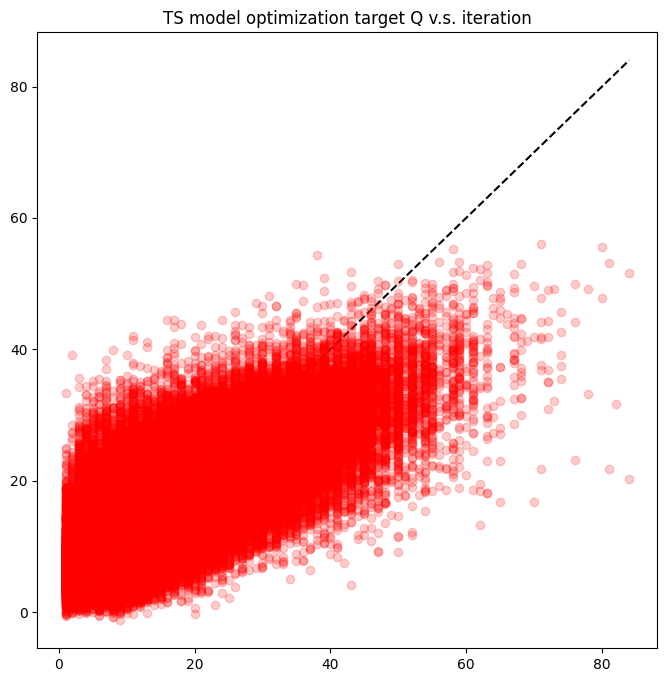

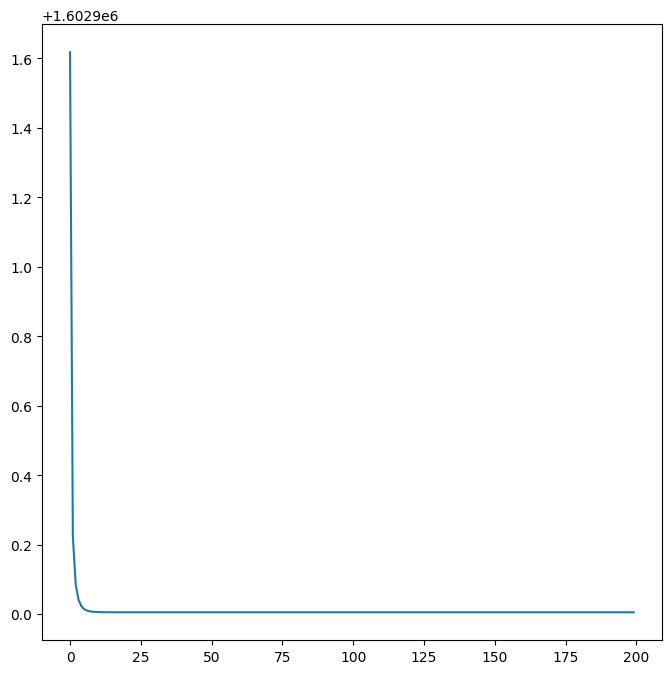

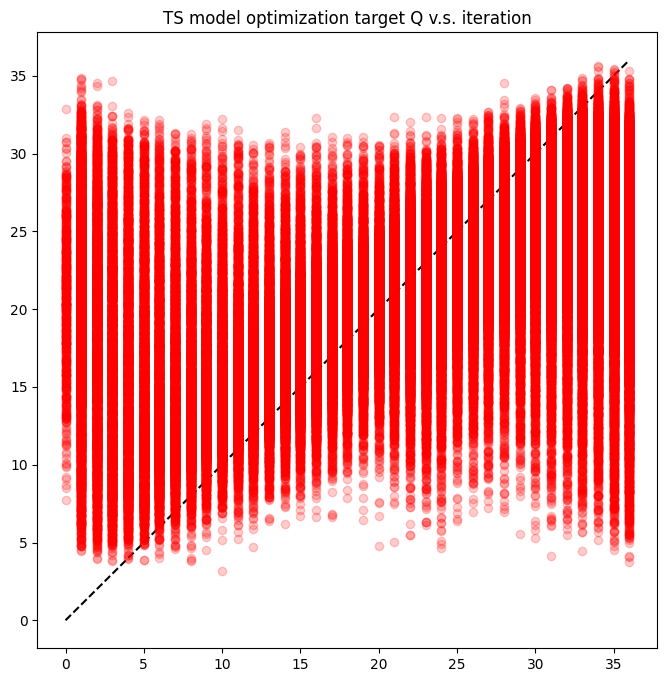

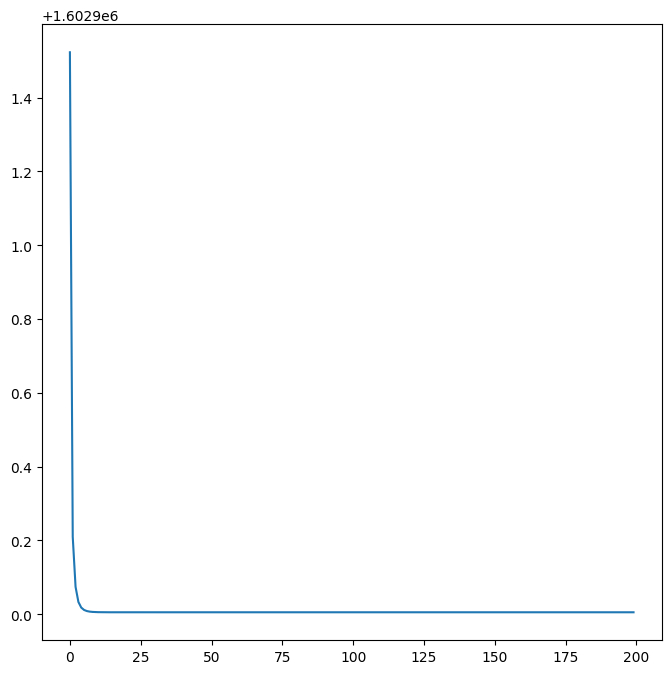

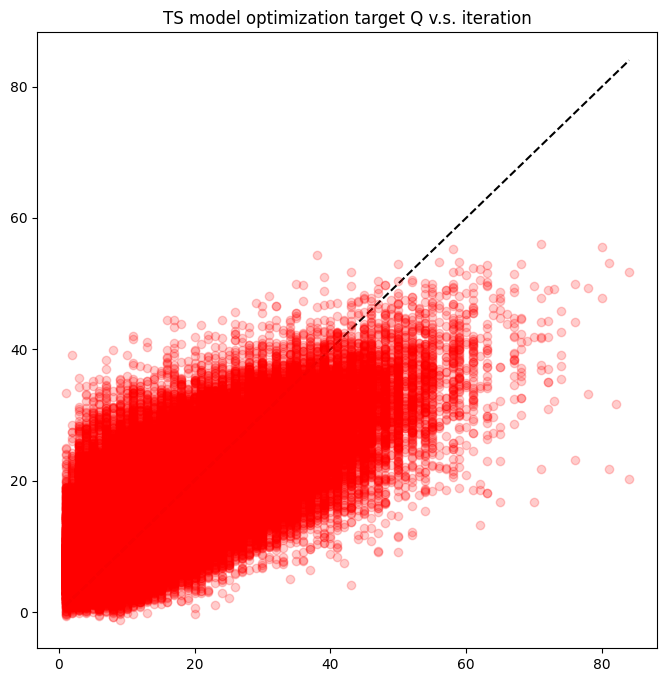

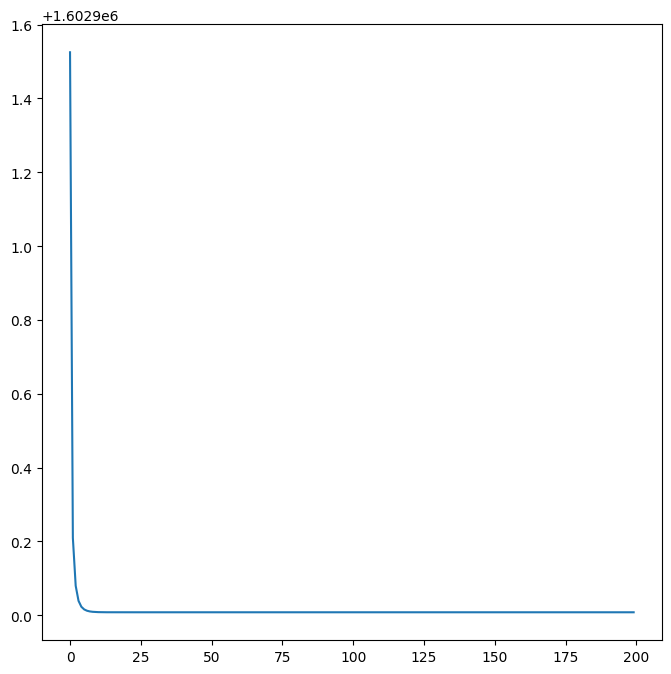

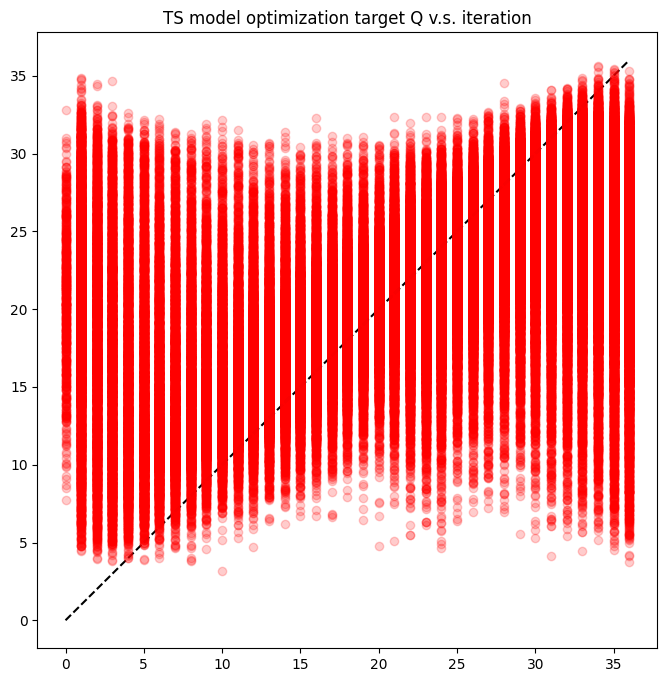

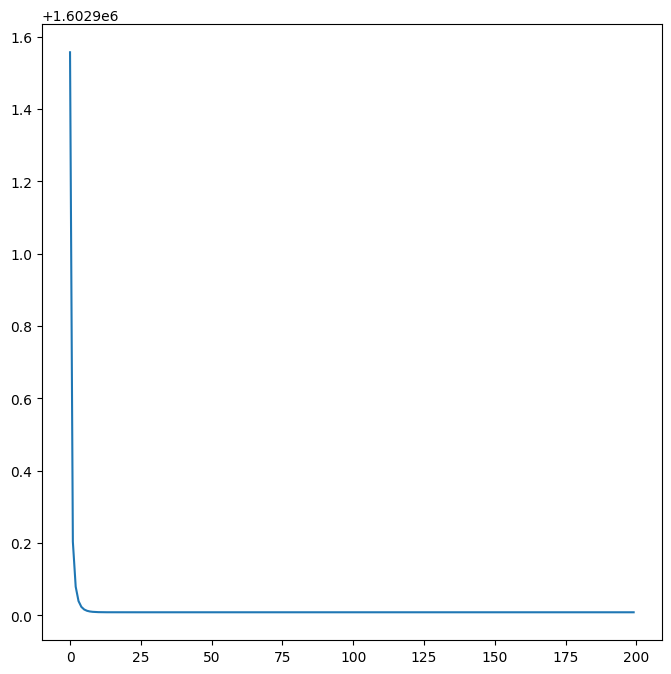

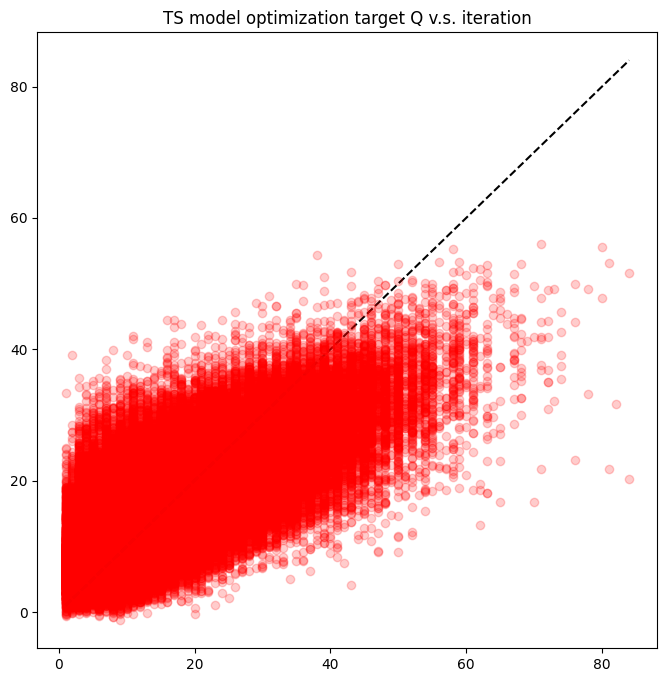

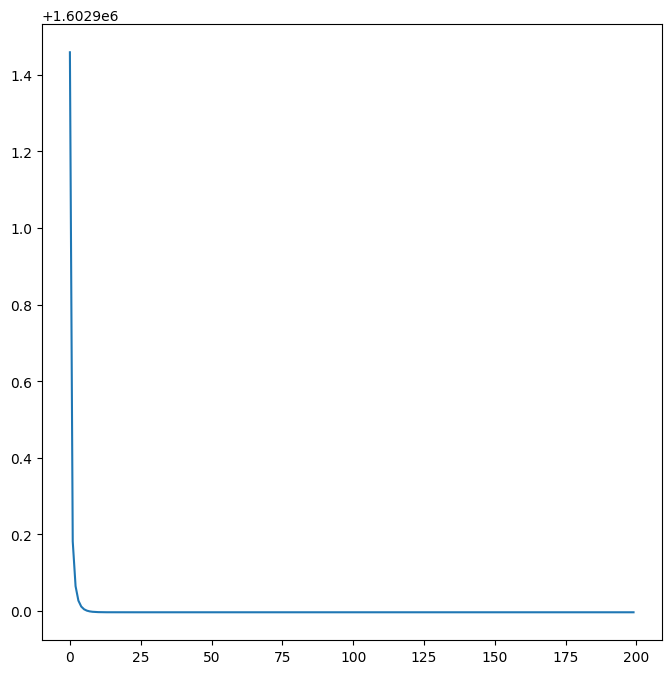

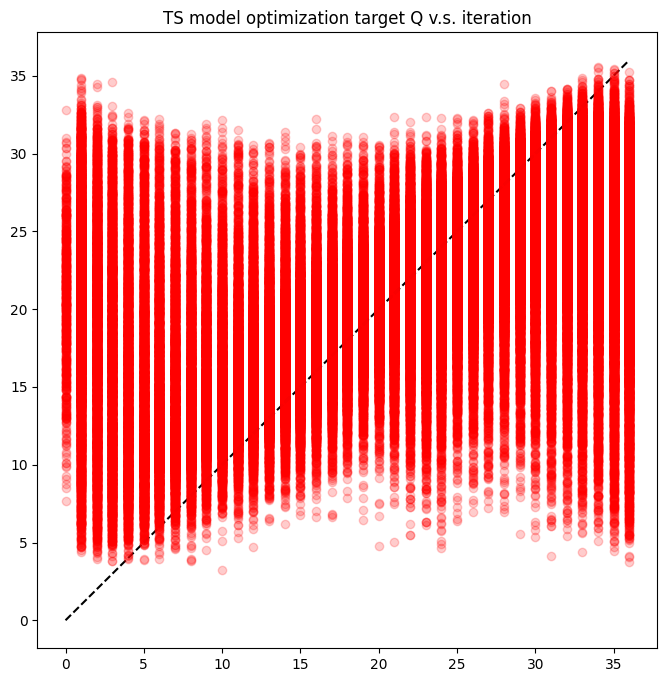

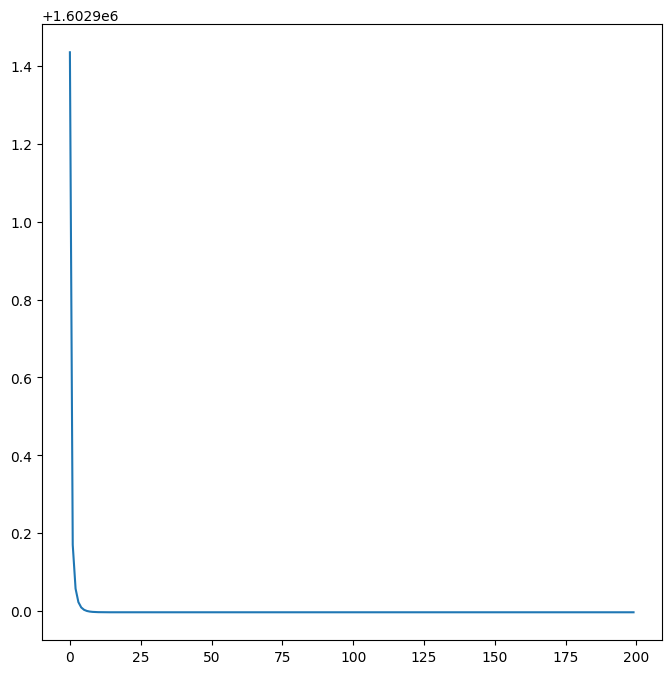

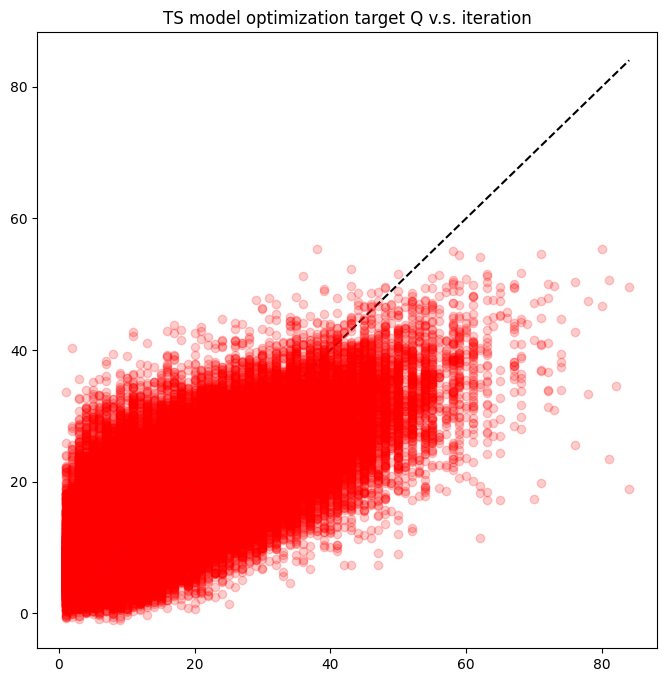

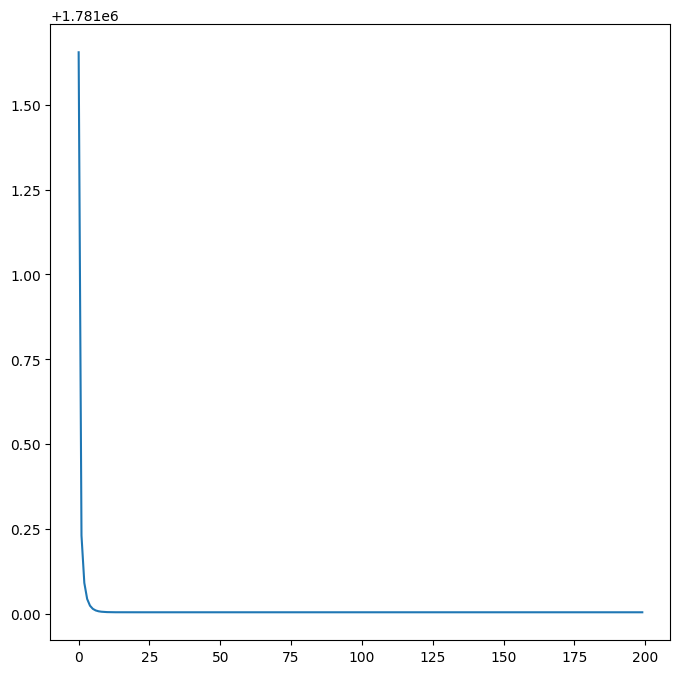

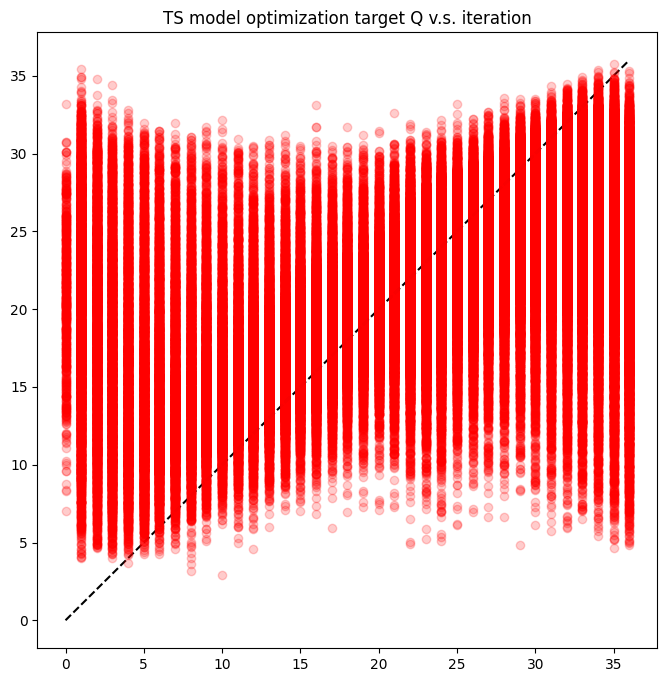

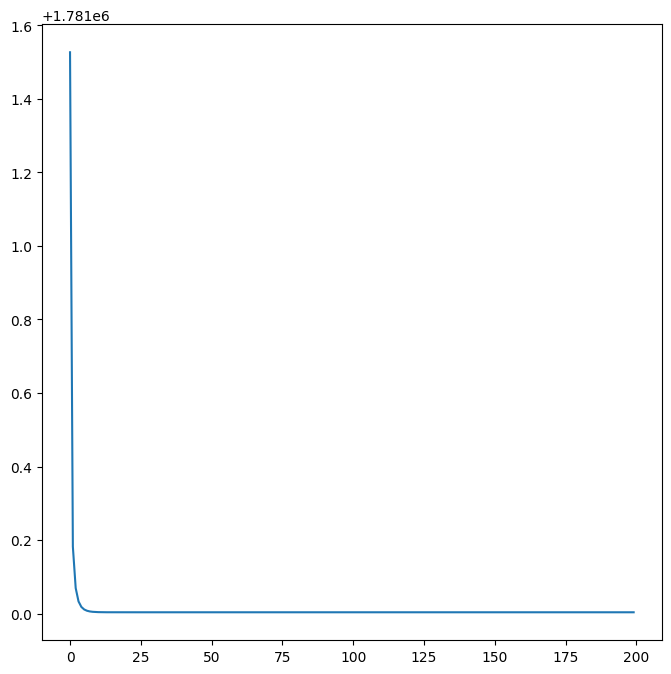

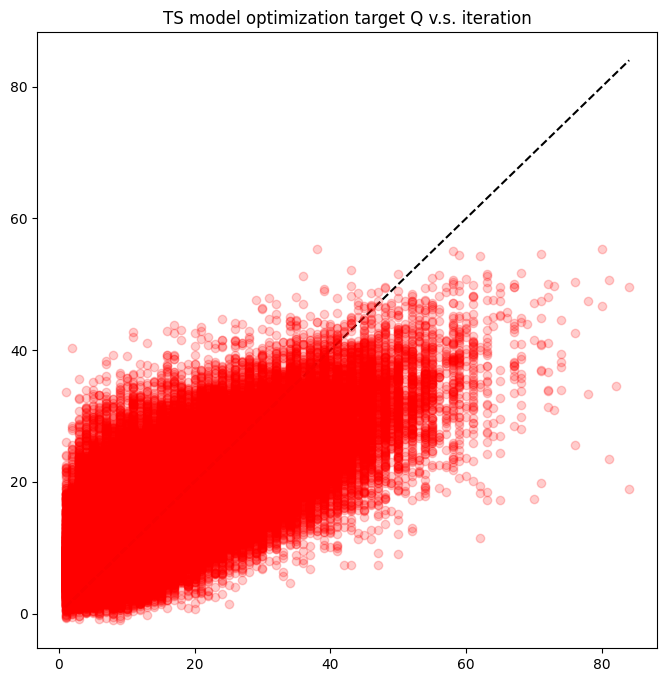

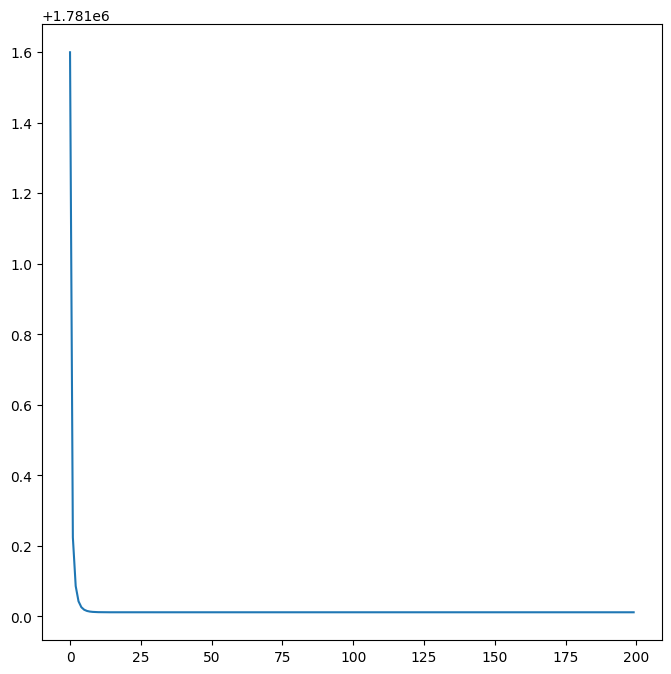

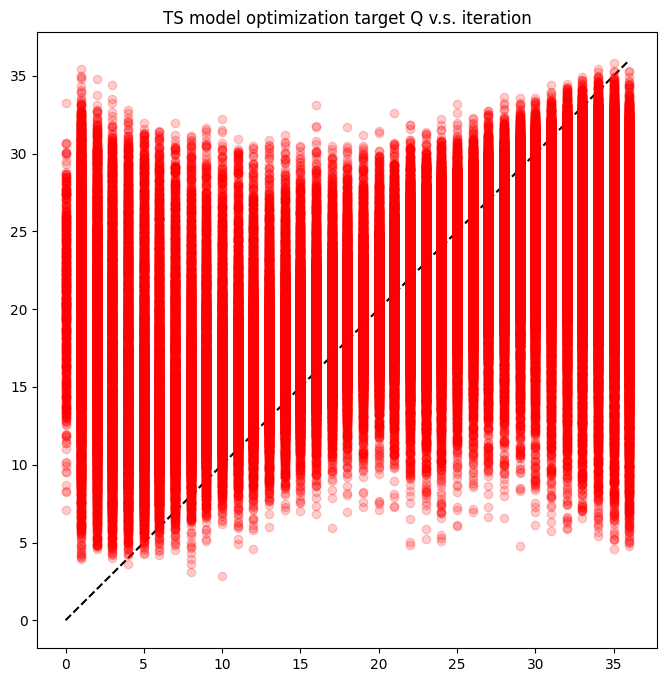

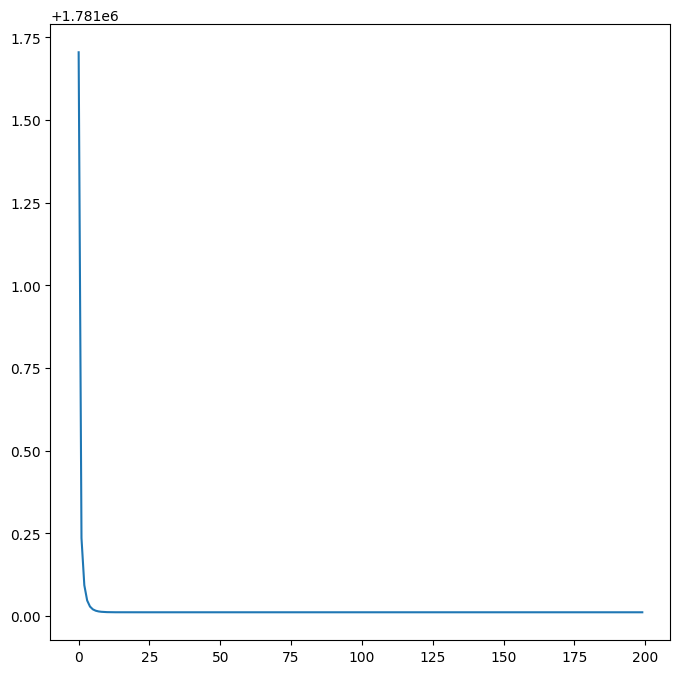

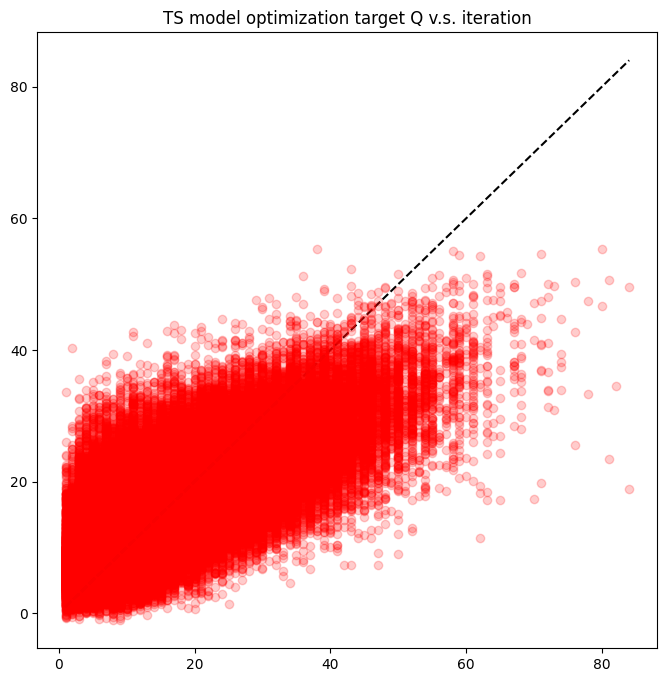

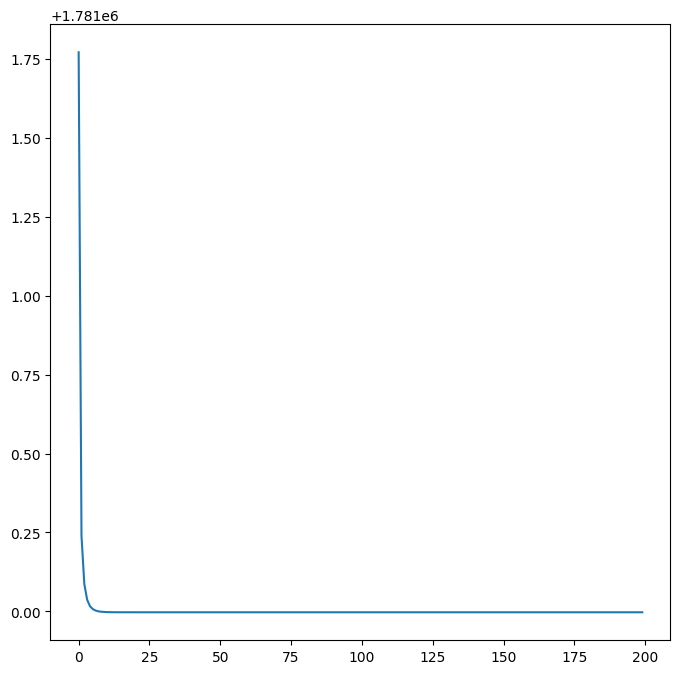

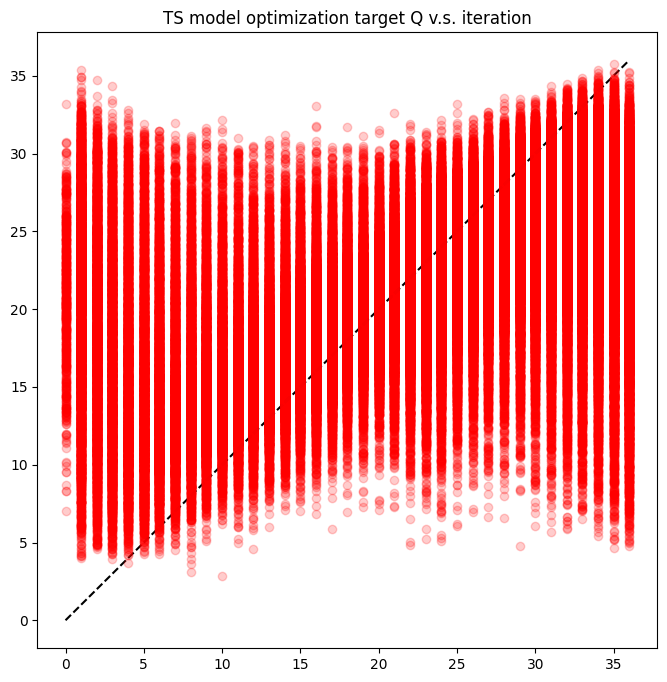

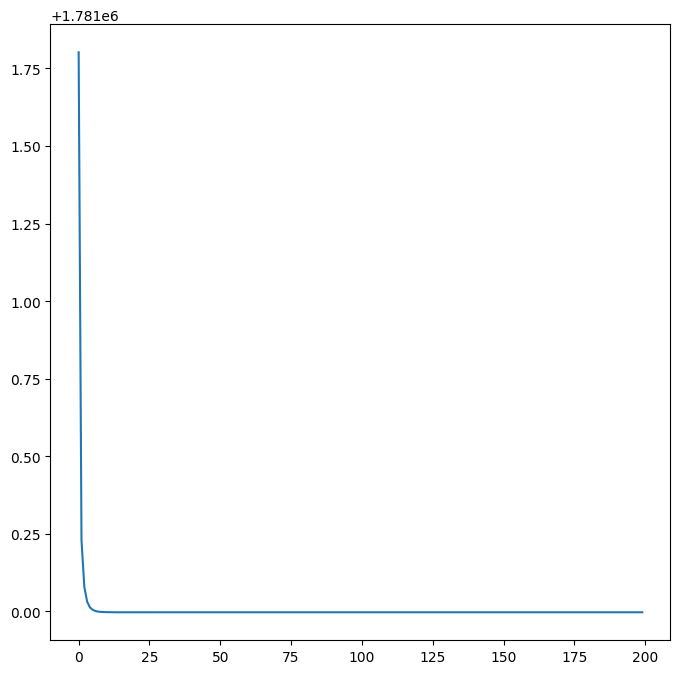

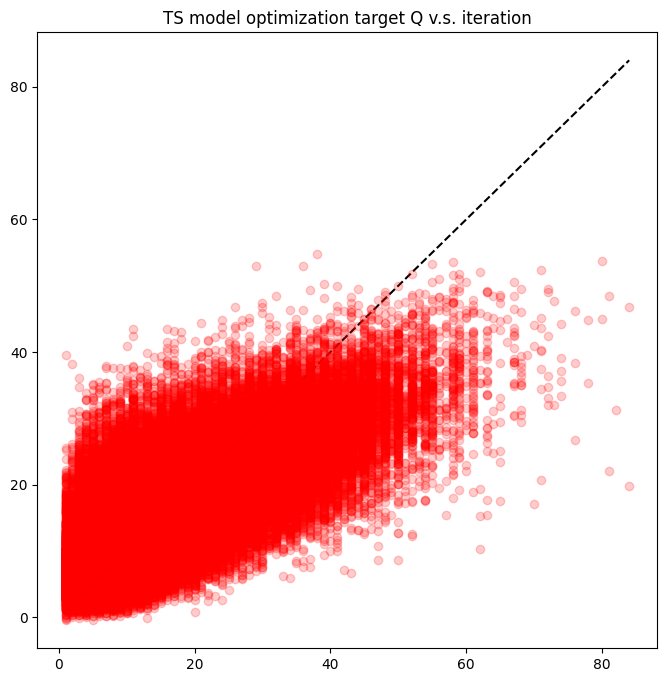

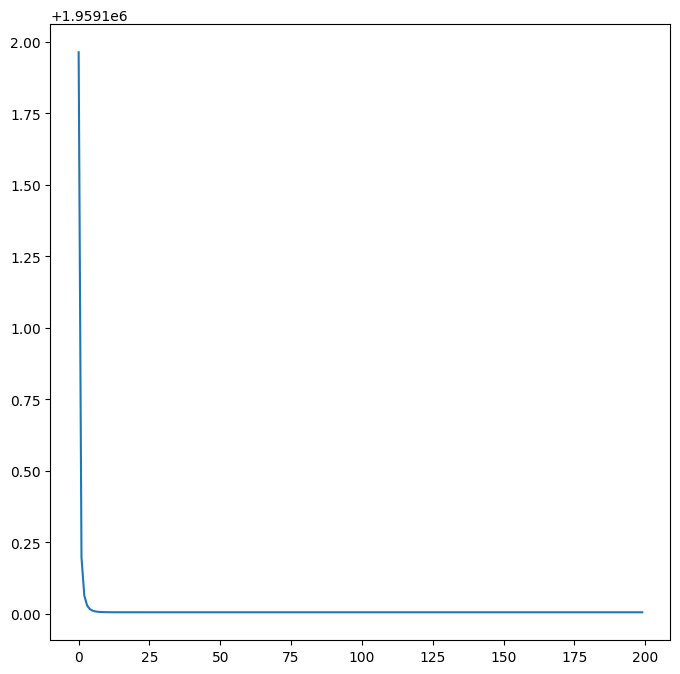

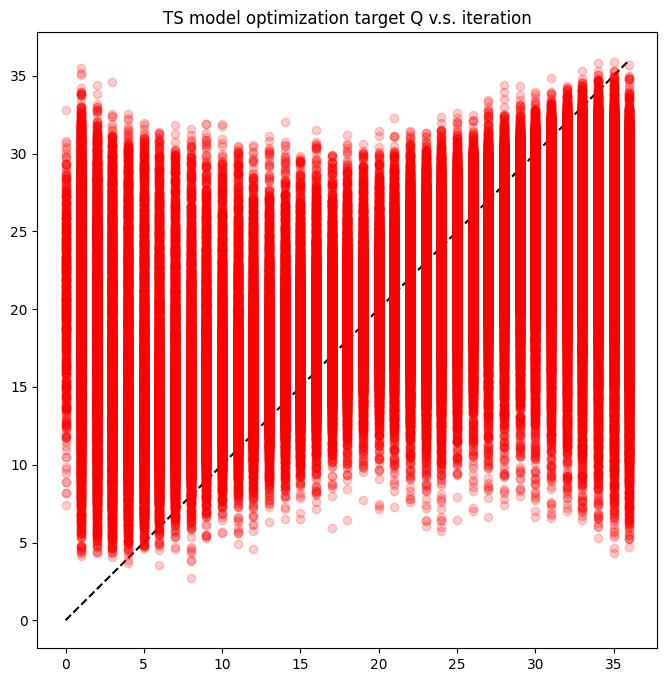

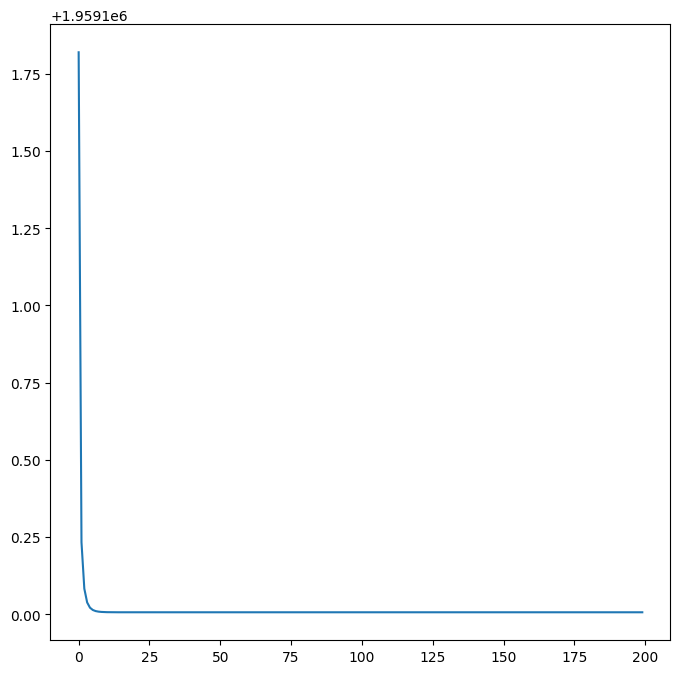

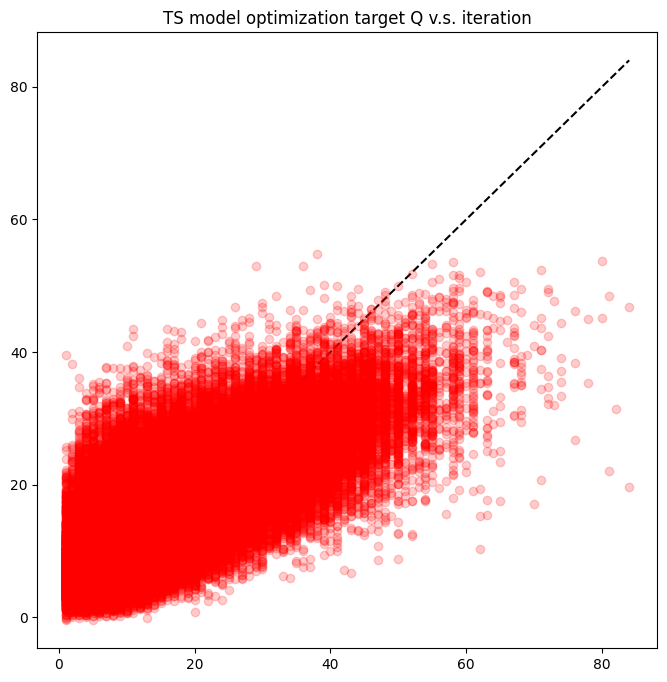

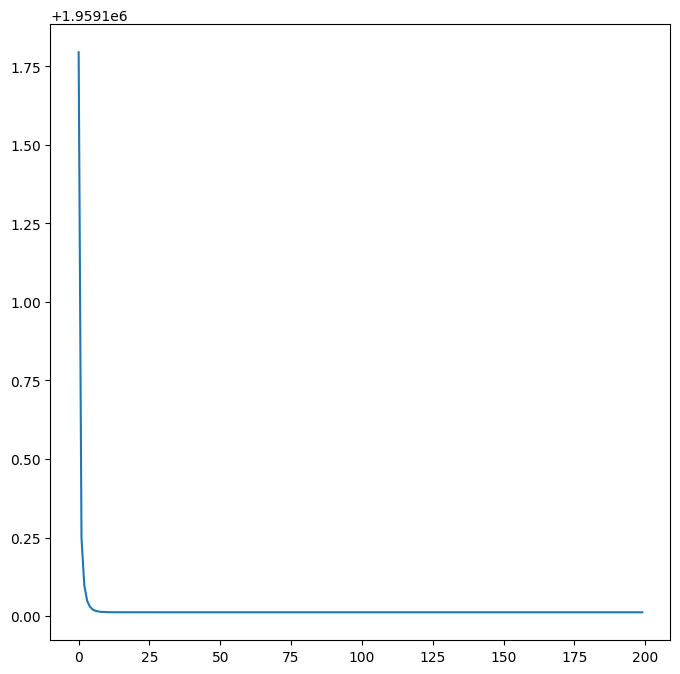

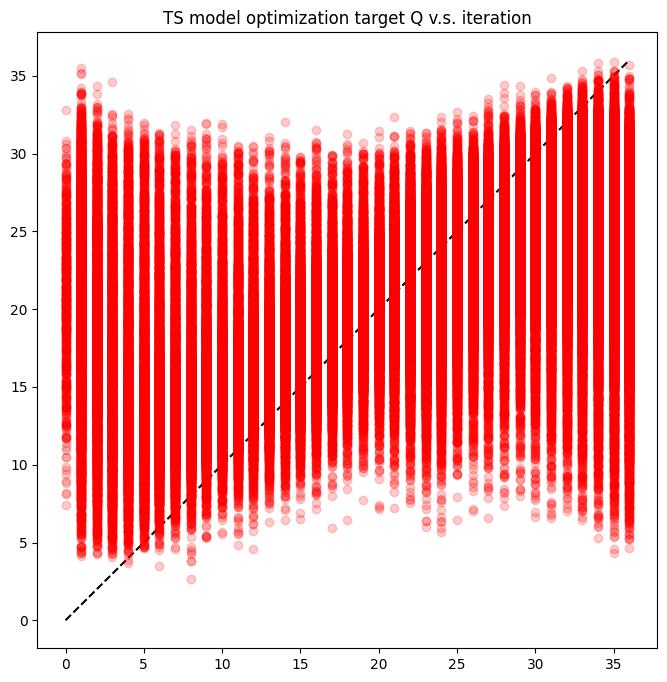

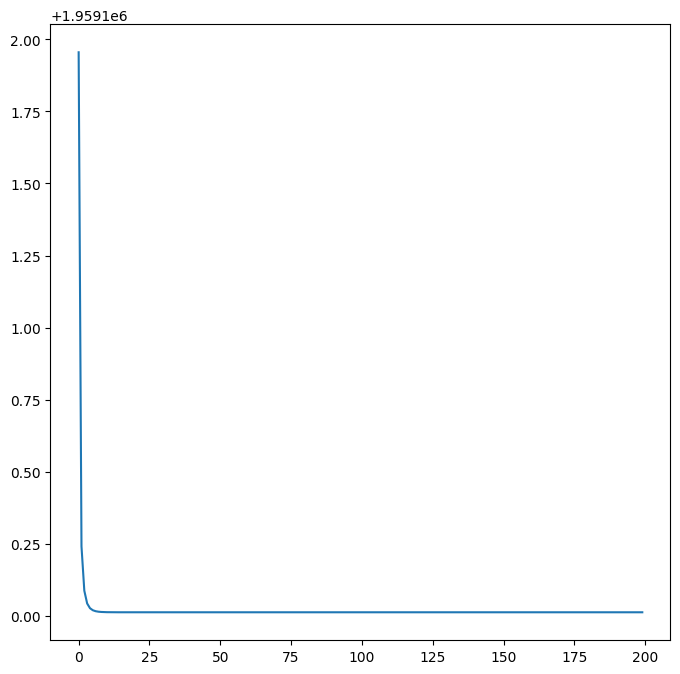

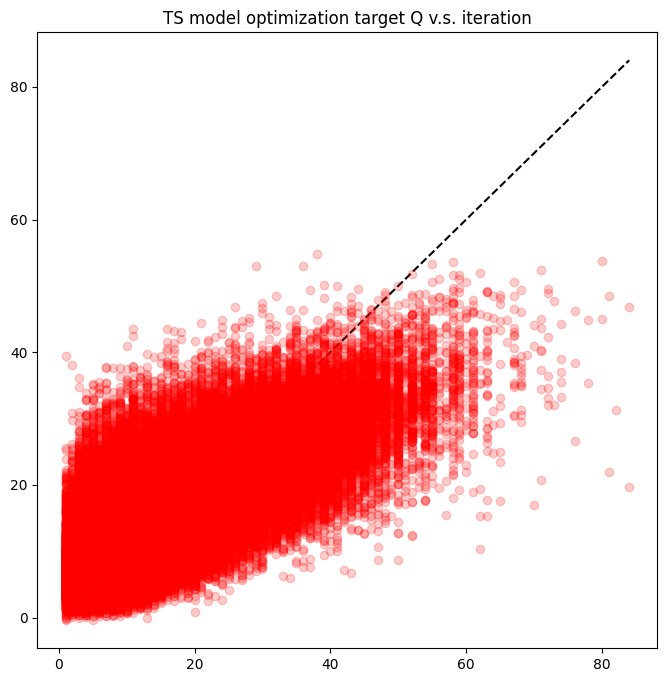

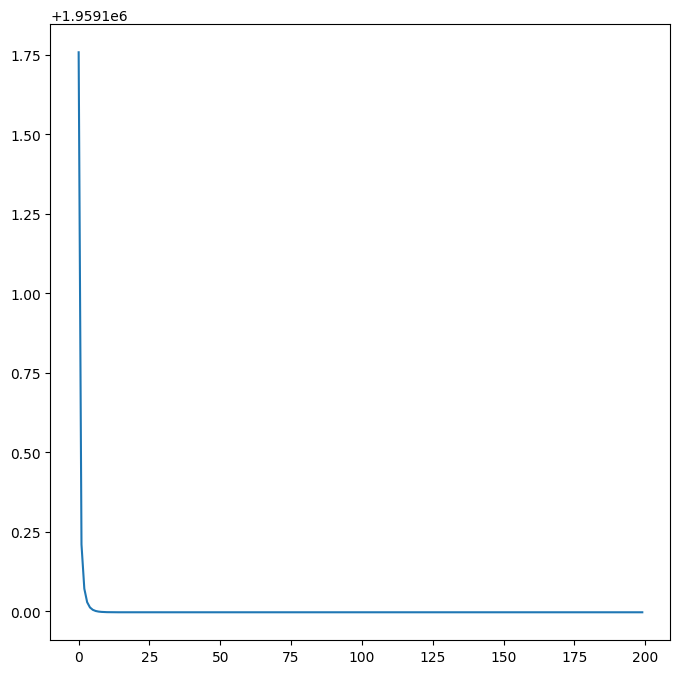

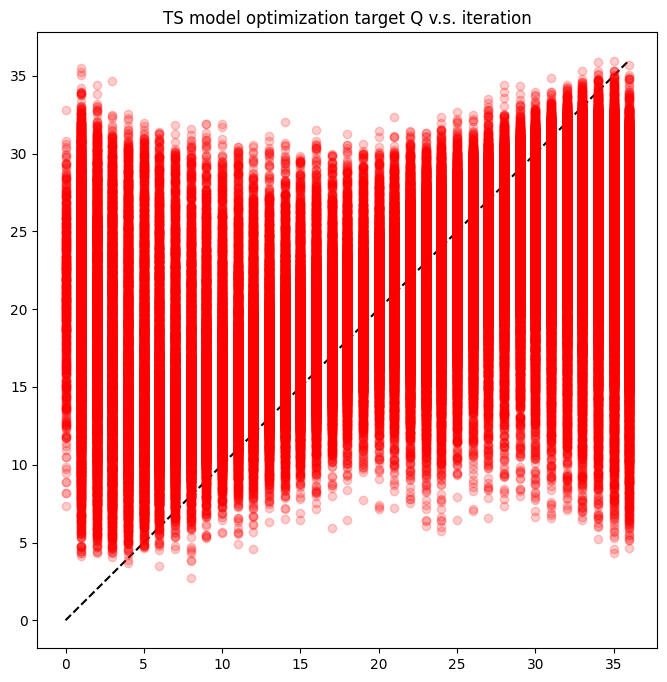

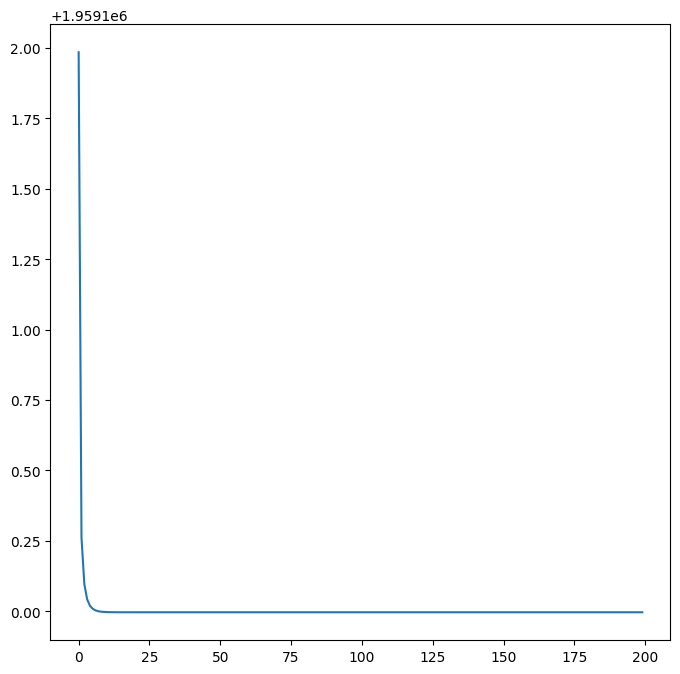

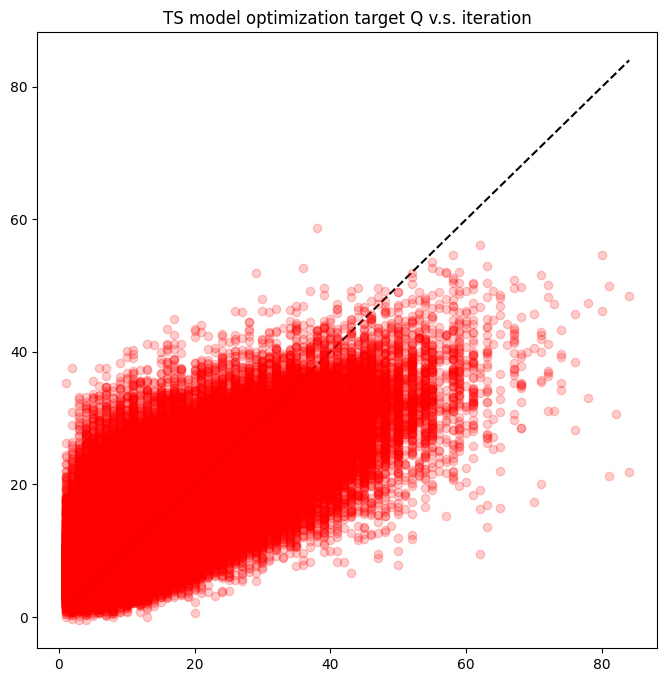

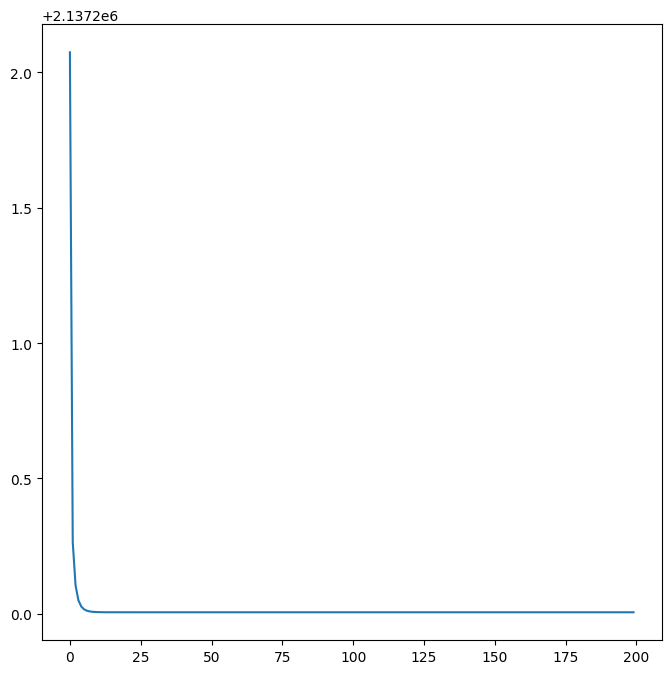

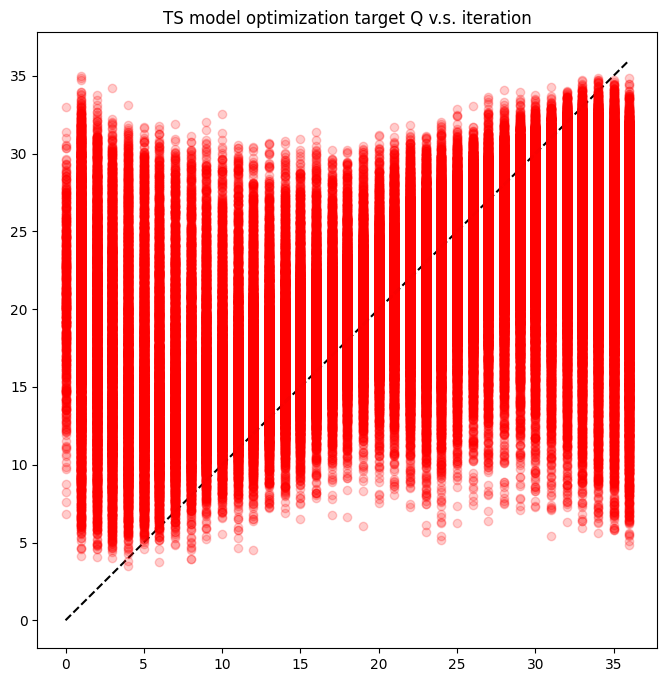

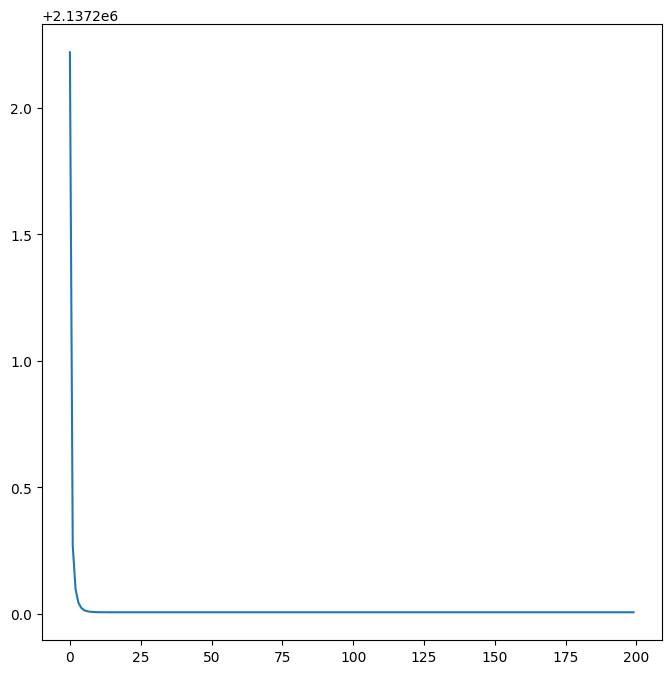

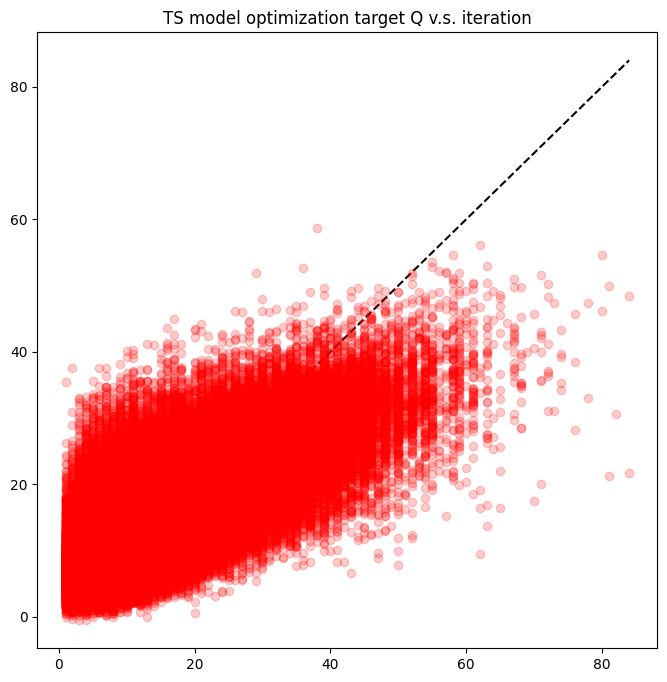

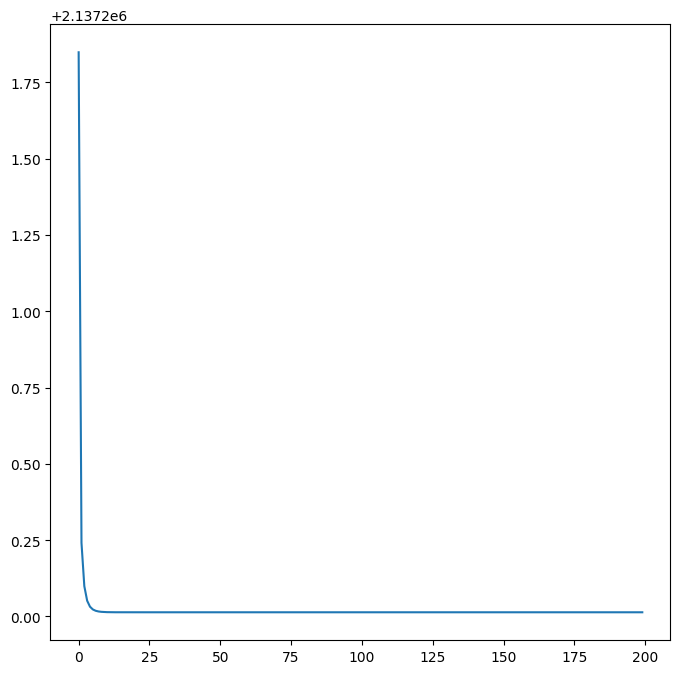

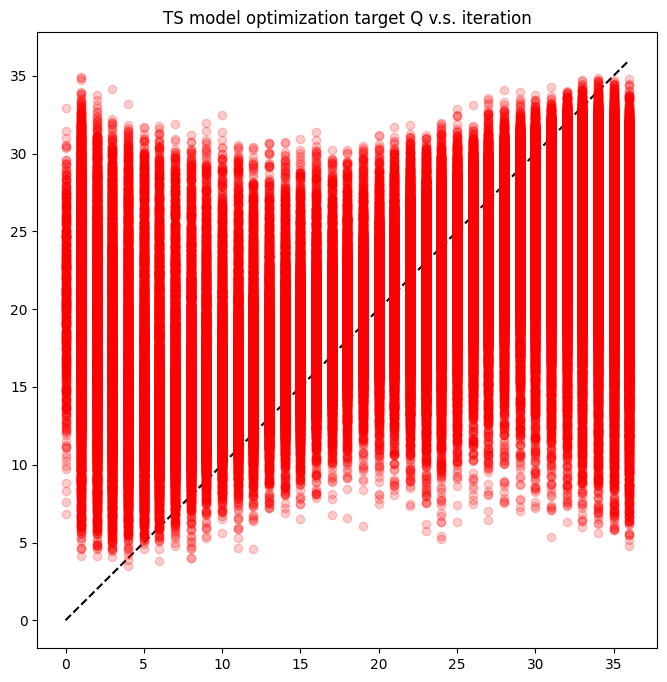

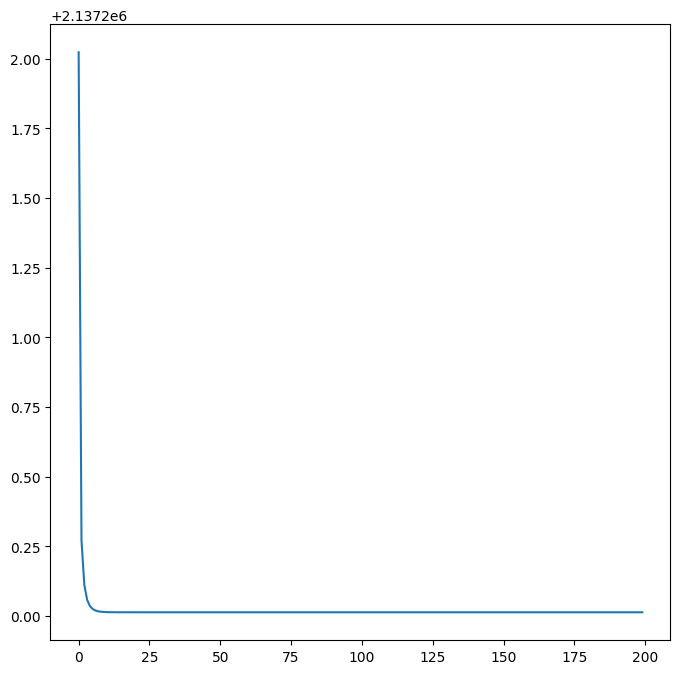

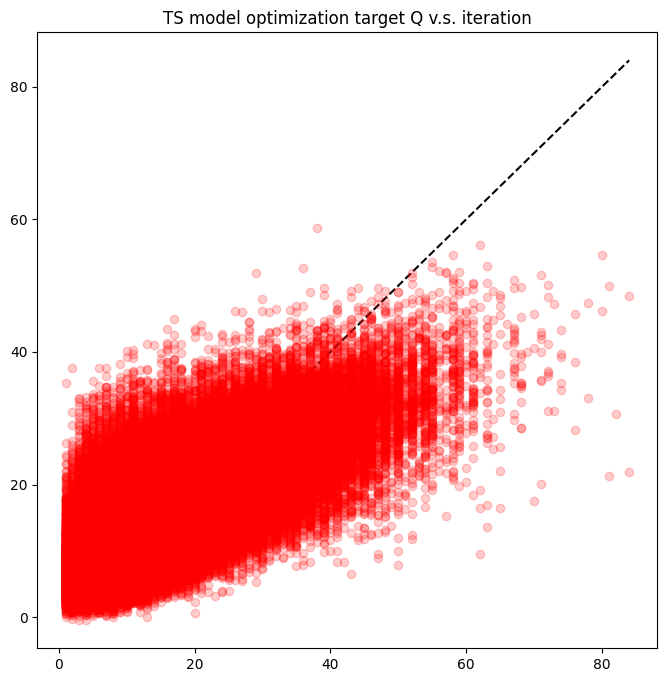

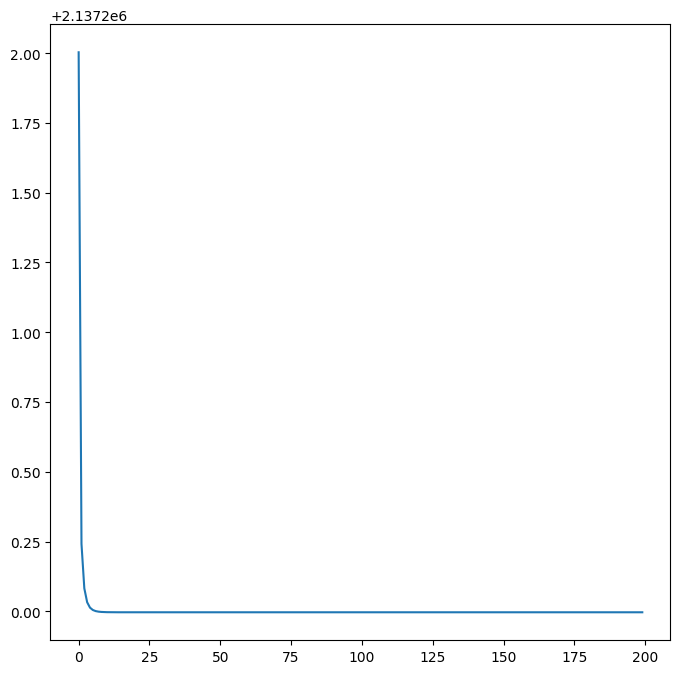

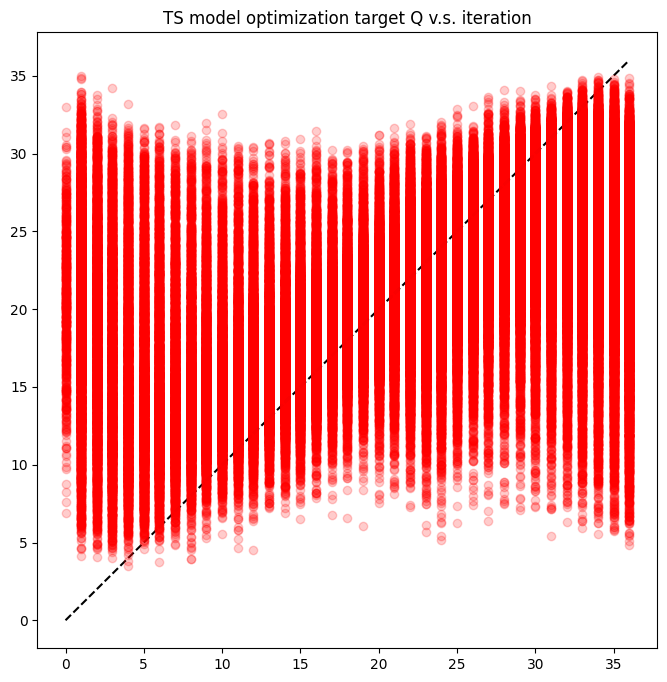

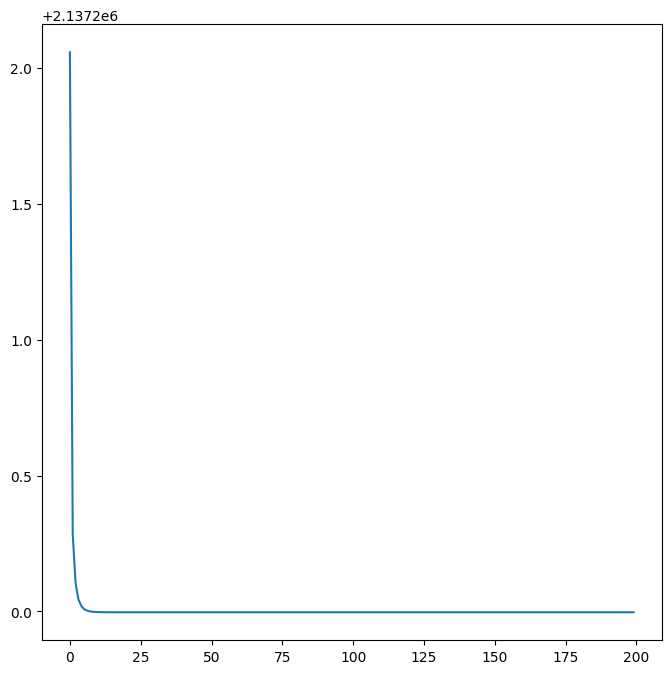

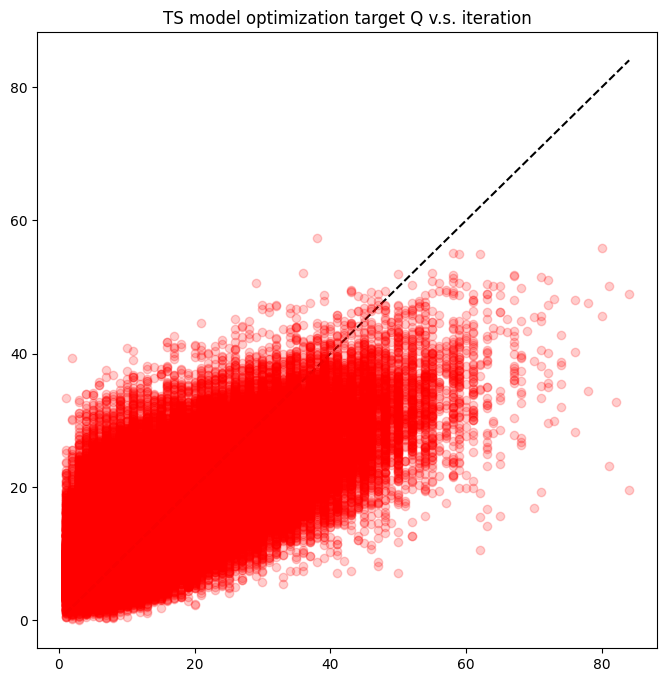

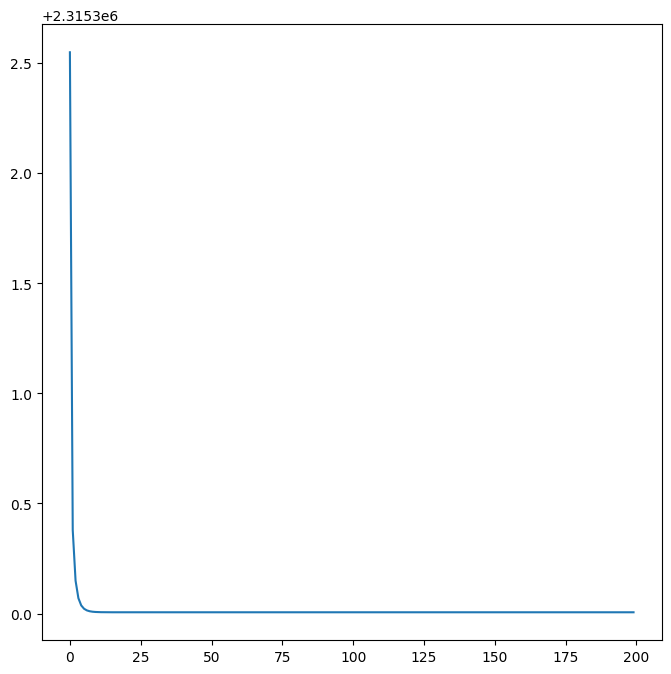

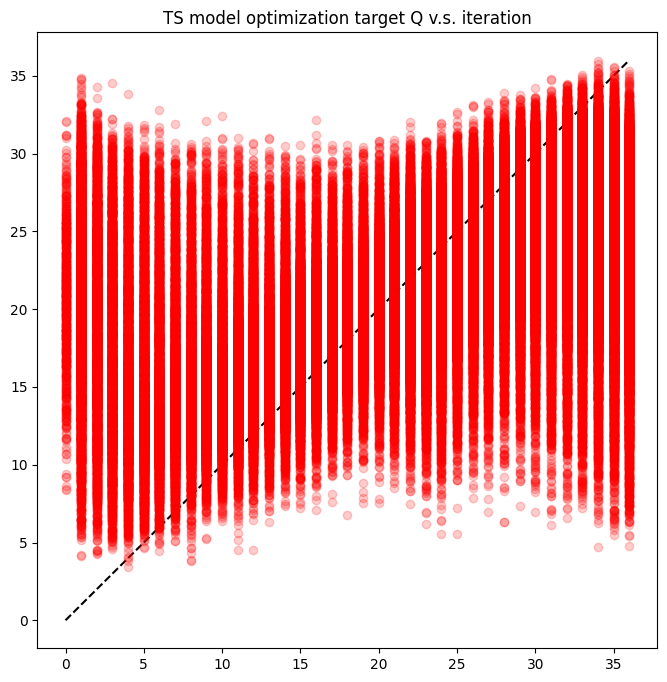

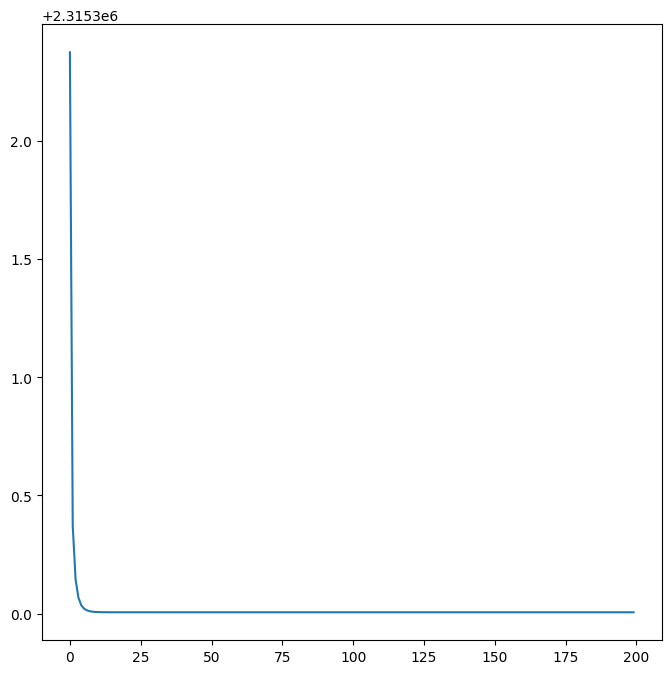

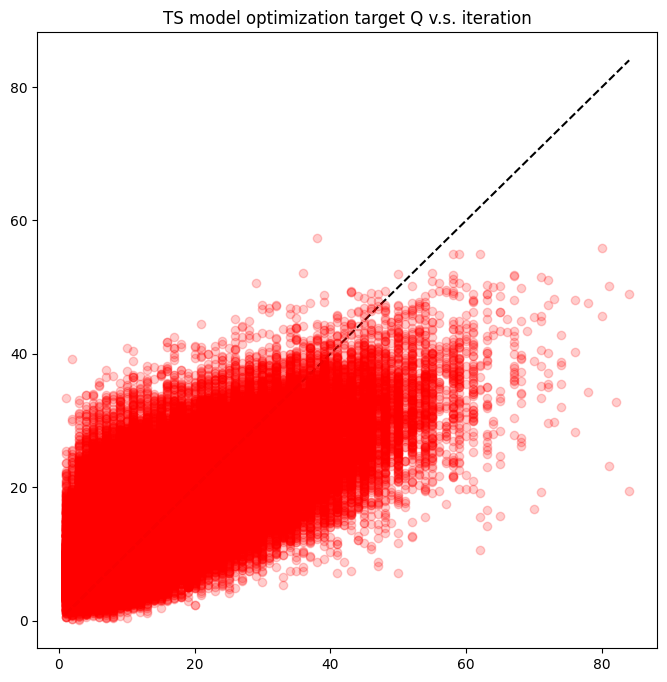

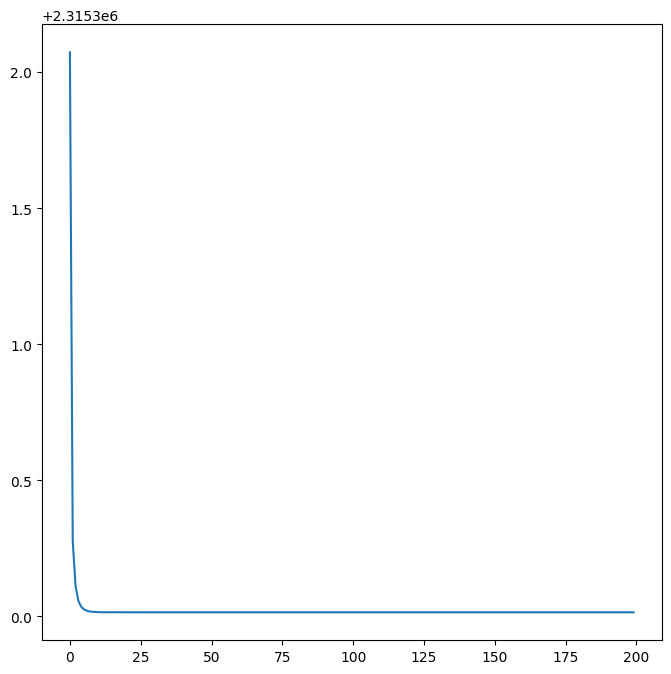

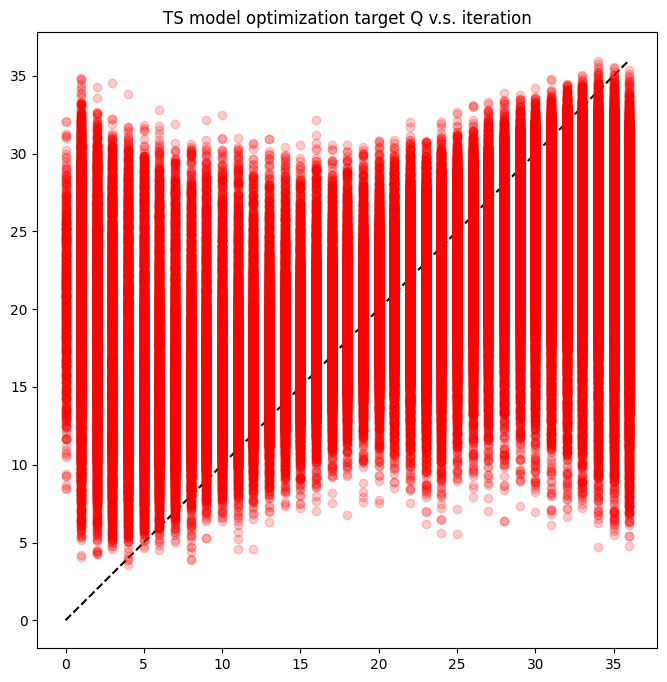

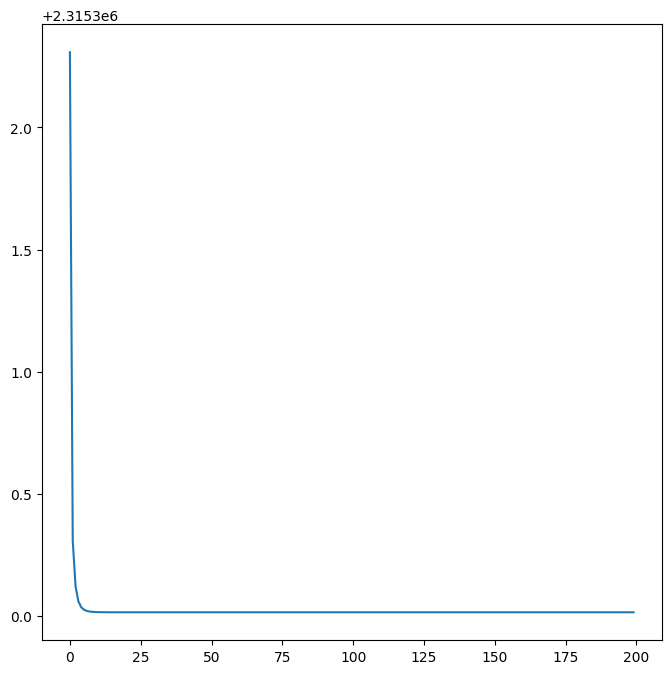

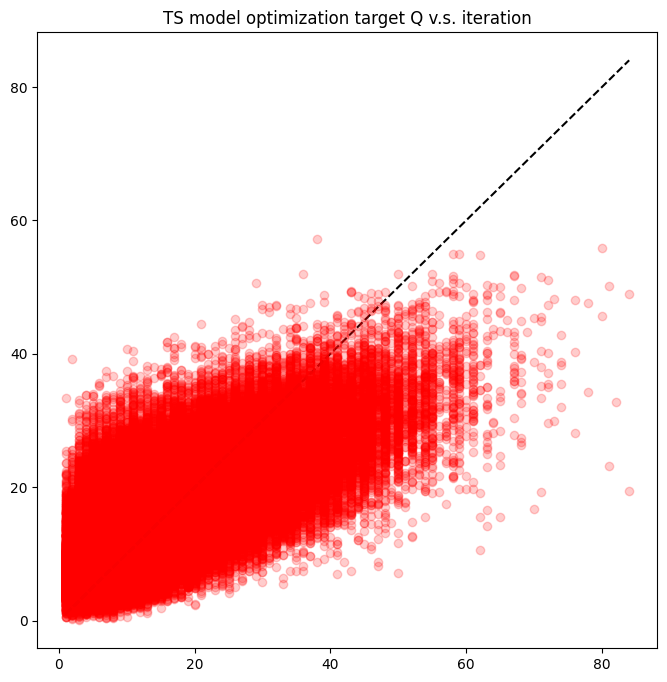

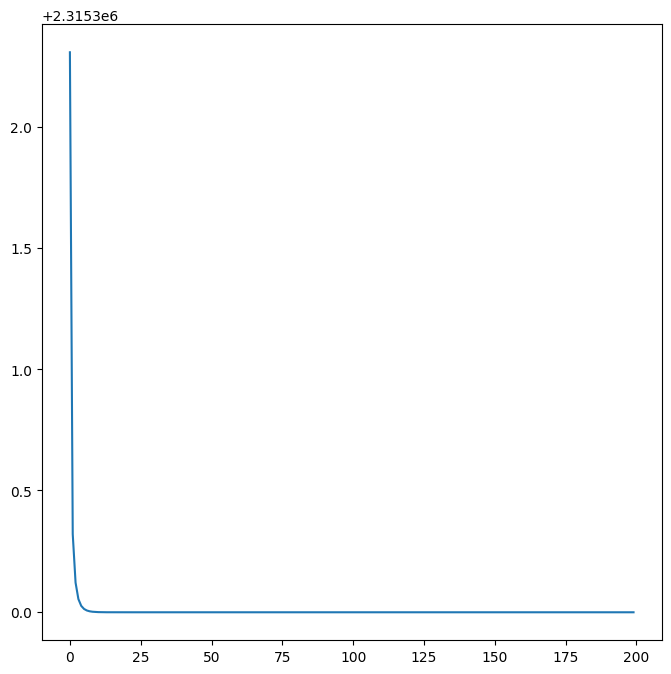

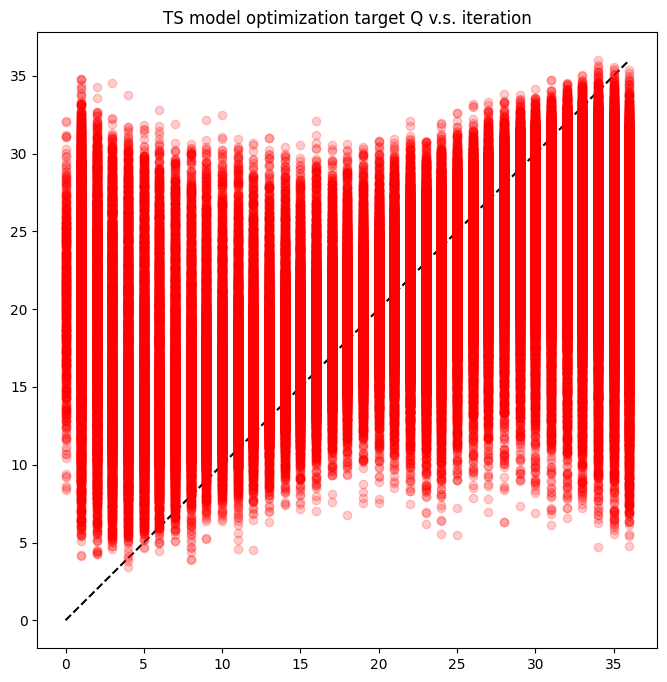

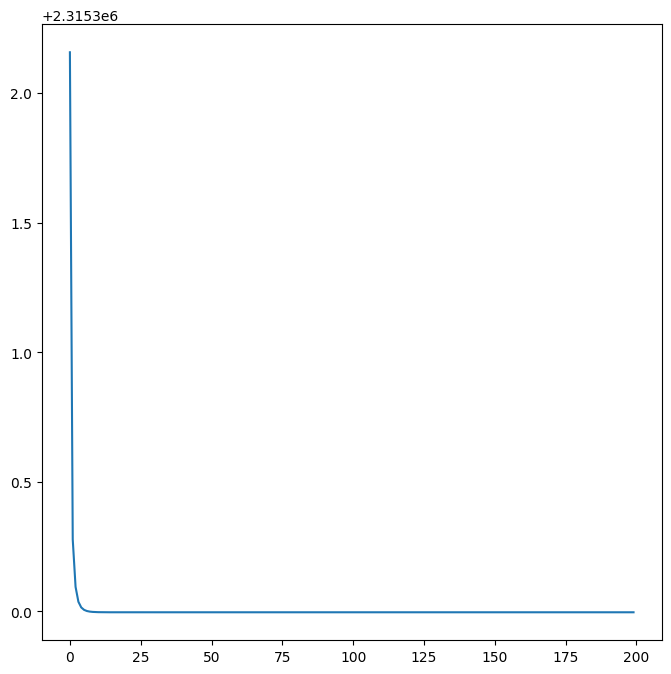

In [76]:
do_experiment(number_of_neighbour_stations, train_data, test_data)

In [78]:
y2_training_results

[[{'linear_train': 8.046025},
  {'fcm_train': 8.046025},
  {'nn_train': 12.229687225818633},
  {'linear_train': 8.045957},
  {'fcm_train': 8.045957},
  {'nn_train': 13.871476686000824},
  {'linear_train': 8.045972},
  {'fcm_train': 8.045972},
  {'nn_train': 7.489327406883239}],
 [{'linear_train': 8.089374},
  {'fcm_train': 8.089374},
  {'nn_train': 12.233223187923432},
  {'linear_train': 8.089363},
  {'fcm_train': 8.089363},
  {'nn_train': 13.900746393203736},
  {'linear_train': 8.08933},
  {'fcm_train': 8.08933},
  {'nn_train': 12.986406099796294}],
 [{'linear_train': 8.110159},
  {'fcm_train': 8.110159},
  {'nn_train': 12.979786372184753},
  {'linear_train': 8.110082},
  {'fcm_train': 8.110082},
  {'nn_train': 13.871974170207977},
  {'linear_train': 8.110075},
  {'fcm_train': 8.110075},
  {'nn_train': 12.25642284154892}],
 [{'linear_train': 8.137317},
  {'fcm_train': 8.137317},
  {'nn_train': 12.244528067111968},
  {'linear_train': 8.137267},
  {'fcm_train': 8.137267},
  {'nn_train':

exp
8.045999526977539±0.0
8.045999526977539±0.0
11.1968±2.7059
exp
8.089400291442871±0.0
8.089400291442871±0.0
13.0401±0.6818
exp
8.110099792480469±0.0
8.110099792480469±0.0
13.0361±0.6607
exp
8.137299537658691±0.0
8.137299537658691±0.0
12.8177±0.7714
exp
8.178199768066406±0.0
8.178199768066406±0.0
13.0438±0.6703


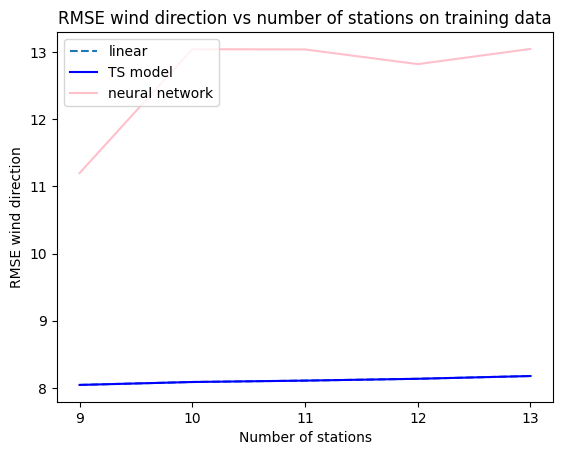

In [79]:
li_train_plot = []
fcm_train_plot = []
nn_train_plot = []
x_axis =  [9, 10,11,12,13]
for exp in y2_training_results:
     li_train_plot.append(np.mean([d['linear_train'] for d in exp if 'linear_train' in d]))
     fcm_train_plot.append(np.mean([d['fcm_train'] for d in exp if 'fcm_train' in d]))
     nn_train_plot.append(np.mean([d['nn_train'] for d in exp if 'nn_train' in d]))

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))
    
plt.plot(x_axis, li_train_plot, '--', label='linear')
plt.plot(x_axis, fcm_train_plot, label='TS model', c='blue')
plt.plot(x_axis, nn_train_plot, label='neural network', c='pink')
plt.legend(loc="upper left")
#plt.ylim(5)
plt.xlabel('Number of stations')
plt.ylabel('RMSE wind direction')
plt.title('RMSE wind direction vs number of stations on training data')

for exp in y2_training_results:
    print('exp')
    print(f"{np.round(np.mean([d['linear_train'] for d in exp if 'linear_train' in d]), 4)}±{np.round(np.std([d['linear_train'] for d in exp if 'linear_train' in d]),4)}")
    print(f"{np.round(np.mean([d['fcm_train'] for d in exp if 'fcm_train' in d]), 4)}±{np.round(np.std([d['fcm_train'] for d in exp if 'fcm_train' in d]),4)}")
    print(f"{np.round(np.mean([d['nn_train'] for d in exp if 'nn_train' in d]), 4)}±{np.round(np.std([d['nn_train'] for d in exp if 'nn_train' in d]),4)}")


exp
6.451300144195557±0.0
6.4513±0.0
6.9334±1.7499
exp
6.4822998046875±0.0
6.4823±0.0
6.9668±1.7281
exp
6.539299964904785±0.0
6.5393±0.0
5.6852±0.0276
exp
6.570899963378906±0.0
6.5708±0.0
6.9622±1.7428
exp
6.636000156402588±0.0
6.6359±0.0
9.4477±0.0204


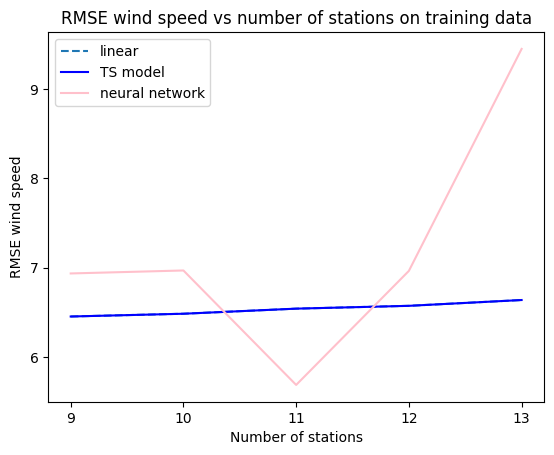

In [80]:
li_train_plot = []
fcm_train_plot = []
nn_train_plot = []
x_axis =  [9, 10,11,12,13]
for exp in y1_training_results:
     li_train_plot.append(np.mean([d['linear_train'] for d in exp if 'linear_train' in d]))
     fcm_train_plot.append(np.mean([d['fcm_train'] for d in exp if 'fcm_train' in d]))
     nn_train_plot.append(np.mean([d['nn_train'] for d in exp if 'nn_train' in d]))

# insert the optimal value from previous experiments 
# li_train_plot.insert(1, 6.7202)
# fcm_train_plot.insert(1, 6.6459)
# nn_train_plot.insert(1, 5.8963)

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))
    
plt.plot(x_axis, li_train_plot, '--', label='linear')
plt.plot(x_axis, fcm_train_plot, label='TS model', c='blue')
plt.plot(x_axis, nn_train_plot, label='neural network', c='pink')
plt.legend(loc="upper left")
#plt.ylim(5)
plt.xlabel('Number of stations')
plt.ylabel('RMSE wind speed')
plt.title('RMSE wind speed vs number of stations on training data')

for exp in y1_training_results:
    print('exp')
    print(f"{np.round(np.mean([d['linear_train'] for d in exp if 'linear_train' in d]), 4)}±{np.round(np.std([d['linear_train'] for d in exp if 'linear_train' in d]),4)}")
    print(f"{np.round(np.mean([d['fcm_train'] for d in exp if 'fcm_train' in d]), 4)}±{np.round(np.std([d['fcm_train'] for d in exp if 'fcm_train' in d]),4)}")
    print(f"{np.round(np.mean([d['nn_train'] for d in exp if 'nn_train' in d]), 4)}±{np.round(np.std([d['nn_train'] for d in exp if 'nn_train' in d]),4)}")


exp
8.053500175476074±0.0
8.0533±0.0
11.9313±1.6782
exp
8.096799850463867±0.0
8.0968±0.0001
13.1813±0.3787
exp
8.11970043182373±0.0
8.1197±0.0
13.1887±0.3726
exp
8.146900177001953±0.0
8.147±0.0
12.9474±0.4102
exp
8.184300422668457±9.999999747378752e-05
8.1845±0.0
13.1898±0.3781


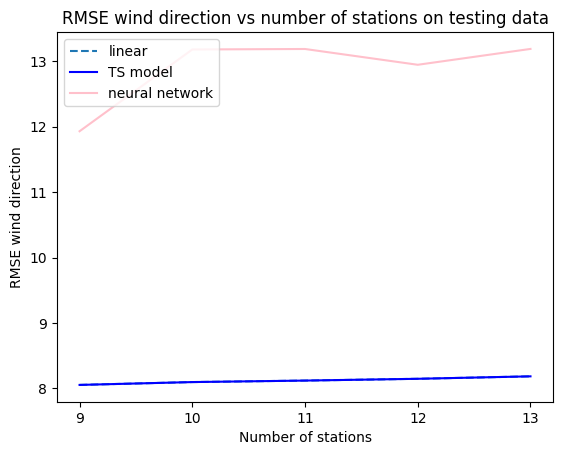

In [81]:
li_train_plot = []
fcm_train_plot = []
nn_train_plot = []
x_axis = [9, 10,11,12,13]
for exp in y2_test_results:
     li_train_plot.append(np.mean([d['linear_test'] for d in exp if 'linear_test' in d]))
     fcm_train_plot.append(np.mean([d['fcm_test'] for d in exp if 'fcm_test' in d]))
     nn_train_plot.append(np.mean([d['nn_test'] for d in exp if 'nn_test' in d]))

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.plot(x_axis, li_train_plot, '--', label='linear')
plt.plot(x_axis, fcm_train_plot, label='TS model', c='blue')
plt.plot(x_axis, nn_train_plot, label='neural network', c='pink')
plt.legend(loc="upper left")
#plt.ylim(15)
plt.xlabel('Number of stations')
plt.ylabel('RMSE wind direction')
plt.title('RMSE wind direction vs number of stations on testing data')

for exp in y2_test_results:
    print('exp')
    print(f"{np.round(np.mean([d['linear_test'] for d in exp if 'linear_test' in d]), 4)}±{np.round(np.std([d['linear_test'] for d in exp if 'linear_test' in d]),4)}")
    print(f"{np.round(np.mean([d['fcm_test'] for d in exp if 'fcm_test' in d]), 4)}±{np.round(np.std([d['fcm_test'] for d in exp if 'fcm_test' in d]),4)}")
    print(f"{np.round(np.mean([d['nn_test'] for d in exp if 'nn_test' in d]), 4)}±{np.round(np.std([d['nn_test'] for d in exp if 'nn_test' in d]),4)}")


exp
6.454699993133545±0.0
6.4546±0.0
10.6604±1.4202
exp
6.490499973297119±0.0
6.4906±0.0
10.6811±1.4131
exp
6.555099964141846±0.0
6.5551±0.0
9.6551±0.0239
exp
6.583600044250488±0.0
6.5836±0.0
10.6525±1.4305
exp
6.649700164794922±9.999999747378752e-05
6.6495±0.0
12.6767±0.0062


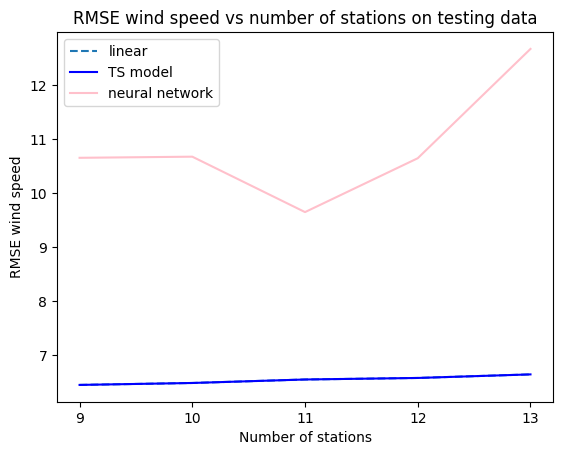

In [82]:
li_train_plot = []
fcm_train_plot = []
nn_train_plot = []
x_axis =  [9, 10,11,12,13]
for exp in y1_test_results:
     li_train_plot.append(np.mean([d['linear_test'] for d in exp if 'linear_test' in d]))
     fcm_train_plot.append(np.mean([d['fcm_test'] for d in exp if 'fcm_test' in d]))
     nn_train_plot.append(np.mean([d['nn_test'] for d in exp if 'nn_test' in d]))

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.plot(x_axis, li_train_plot, '--', label='linear')
plt.plot(x_axis, fcm_train_plot, label='TS model', c='blue')
plt.plot(x_axis, nn_train_plot, label='neural network', c='pink')
plt.legend(loc="upper left")
#plt.ylim(5)
plt.xlabel('Number of stations')
plt.ylabel('RMSE wind speed')
plt.title('RMSE wind speed vs number of stations on testing data')

for exp in y1_test_results:
    print('exp')
    print(f"{np.round(np.mean([d['linear_test'] for d in exp if 'linear_test' in d]), 4)}±{np.round(np.std([d['linear_test'] for d in exp if 'linear_test' in d]),4)}")
    print(f"{np.round(np.mean([d['fcm_test'] for d in exp if 'fcm_test' in d]), 4)}±{np.round(np.std([d['fcm_test'] for d in exp if 'fcm_test' in d]),4)}")
    print(f"{np.round(np.mean([d['nn_test'] for d in exp if 'nn_test' in d]), 4)}±{np.round(np.std([d['nn_test'] for d in exp if 'nn_test' in d]),4)}")


[1.9767817656199138, 2.46142586072286, 2.7553628285725913, 3.323885917663574, 2.8977599143981934]
[512.7941346168518, 554.5792395273844, 599.7389996846517, 651.5220998922983, 694.3879208564758]
[3343.2267429828644, 3349.128043333689, 3277.0516350269318, 3310.262555996577, 3258.0790873368583]


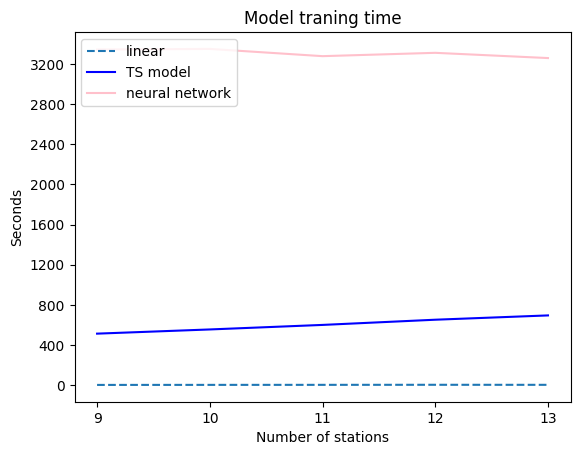

In [83]:
li_time_plot = []
fcm_time_plot = []
nn_time_plot = []
x_axis =  [9, 10,11,12,13]
for exp in training_times:
    li_time_plot.append(np.mean([d['linear_train'] for d in exp if 'linear_train' in d]))
    fcm_time_plot.append(np.mean([d['fcm_train'] for d in exp if 'fcm_train' in d]))
    nn_time_plot.append(np.mean([d['nn_train'] for d in exp if 'nn_train' in d]))

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))
    
plt.plot(x_axis, li_time_plot, '--', label='linear')
plt.plot(x_axis, fcm_time_plot, label='TS model', c='blue')
plt.plot(x_axis, nn_time_plot, label='neural network', c='pink')
plt.legend(loc="upper left")
plt.xlabel('Number of stations')
plt.ylabel('Seconds')
plt.title('Model traning time')

print(li_time_plot)
print(fcm_time_plot)
print(nn_time_plot)

Text(0.5, 1.0, 'Loss vs number of epoches')

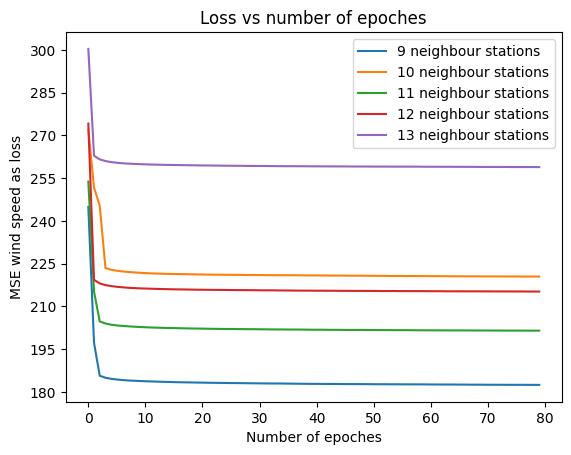

In [85]:
i = 1
fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))

for exp in nn_histories[0:5]:
    nn_losses = []
    for fold in exp:
        nn_losses.append(fold['loss'])
    plt.plot(np.mean(nn_losses, axis=0), label=f"{i+8} neighbour stations")
    i = i+1


plt.legend(loc="upper right")
#plt.ylim(5)
plt.xlabel('Number of epoches')
plt.ylabel('MSE wind speed as loss')
plt.title('Loss vs number of epoches')

In [38]:
opt_x = pd.read_csv('Data/exp/with_season_multi_2_x_test.csv', index_col=0) #with_season_multi_9_x_test
opt_y = pd.read_csv('Data/exp/with_season_multi_2_y_test.csv', index_col=0)

In [34]:
#scaler = StandardScaler()
#opt_x = scaler.fit_transform(opt_x)
opt_y = np.array(opt_y)[:,1]
opt_x, opt_y = shuffle(opt_x, opt_y)

In [35]:
# Plot Q vs # of Nc
# Fcm hyperparameters
FCM_Ncs = [2,3,5,8,10,15,20,25,30,40,50,80]
FCM_m = 2
tol = 1e-5
max_iter = 200
qs = []

for FCM_Nc in FCM_Ncs:   
    N = opt_x.shape[0]
    U = np.random.rand(N, FCM_Nc)
    U = U / np.sum(U, axis=1, keepdims=True)
    temp_qs = []

    # Fuzzy C-Means 聚类
    for _ in range(max_iter):
        U_old = U.copy()
        mf = U ** FCM_m
        cen = np.dot(mf.T, opt_x) / np.sum(mf, axis=0, keepdims=True).T
        dists = cdist(opt_x, cen)
        tmp = np.power(dists, -2 / (FCM_m - 1))
        U = tmp / np.sum(tmp, axis=1, keepdims=True)

        q = np.sum((U ** FCM_m) * (dists ** 2))
        temp_qs.append(q)

        # 检查是否收敛
        if np.linalg.norm(U - U_old) < tol:
            break
    # 模型训练 find if this can be optimized
    z = np.hstack((np.ones((N, 1)), opt_x))
    H = np.zeros((N, FCM_Nc * (opt_x.shape[1] + 1)))

    # 生成模糊规则矩阵 H
    for j in range(FCM_Nc):
        Uj = np.tile(U[:, j], (opt_x.shape[1] + 1, 1)).T
        H[:, (j * (opt_x.shape[1] + 1)):((j + 1) * (opt_x.shape[1] + 1))] = Uj * z

    # 计算权重 W
    W = pinv(np.dot(H.T, H)).dot(H.T).dot(opt_y)

        
    # 在训练集上进行预测
    y_hat_train = np.dot(H, W)
    mse_train = mean_squared_error(opt_y, y_hat_train)
    rmse_train = sqrt(mean_squared_error(opt_y, y_hat_train))
    print("FCM traning RMSE:", rmse_train)
    qs.append(temp_qs)


FCM traning RMSE: 8.120516797284086
FCM traning RMSE: 8.071078876473203
FCM traning RMSE: 8.032835913569274
FCM traning RMSE: 8.000557638105866
FCM traning RMSE: 7.96052046239757
FCM traning RMSE: 7.913887243423011
FCM traning RMSE: 7.877634790963088
FCM traning RMSE: 7.856360559719632
FCM traning RMSE: 7.854498413256278
FCM traning RMSE: 7.838315507405848
FCM traning RMSE: 7.819407554057577
FCM traning RMSE: 7.788571842404724


Text(0.5, 1.0, 'TS model optimization target Q v.s. iteration for differenct number of rules')

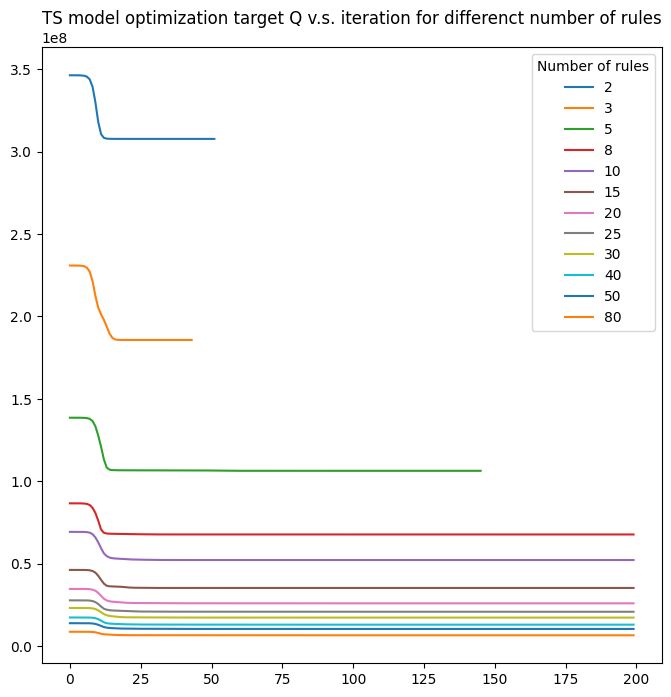

In [37]:
plt.figure(figsize=(8,8))

for exp in qs:
    plt.plot(exp)

plt.legend(FCM_Ncs, title="Number of rules")
plt.title('TS model optimization target Q v.s. iteration for differenct number of rules')